In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
import seaborn as sns

from tqdm import tqdm_notebook as progbar
from collections import deque, Counter, namedtuple
import numpy as np
import pandas as pd
from cycler import cycler
from scipy.stats import rankdata, pearsonr
import scipy.stats as scs
from scipy.special import comb
import statsmodels.api as sm
import os

import loc_utils as lut
import vis_utils as vut
from standards import *

rx = RAWXix()
r = RAWix()

gcolors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']
colors = ['#375e97', '#f18d9e', '#ffbb00', '#3f681c']

glabels = {0: 'F', 1: 'S'}
clabels = {0: 'i-', 1: 'i+'}

def gclabel(g, c):
    return '{}/{}'.format(glabels[g], clabels[c])

tlabels = {
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'R'}

saveloc = '/Users/alexten/Projects/HFSP/img'
desktop = '/Users/alexten/Desktop/'
data_path = 'pipeline_data/s3/joint_data.pkl'


def save_it(fig, savedir, figname, save_as='svg', dpi=500, compress=True):
    s = savedir+'/{}.{}'.format(figname, save_as)
    fig.savefig(s, format=save_as, dpi=500)
    if compress:
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))

# 1. Outliers

### 1.1. Task allocation variance

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'
title = ''
figname = 'task_allocation_variance_clean'
save_as = 'svg'

if 0:
    from s3_remove_outliers import measure_allocation_variance
    fig, ax = plt.subplots(1,1, num=figname, figsize=[8,6])
    
    data = lut.unpickle(path)['main']
    
    data = measure_allocation_variance(data)
    nbins = vut.fd_bins(data)+2
    
    vut.add_stds(ax, data, 10, False)
    sns.despine(top=True, right=True)

    sns.distplot(data, bins = nbins, 
                 rug=True, kde=False,
                 rug_kws={'alpha':0.7, 'height':0.02, 'color':'k', 'linewidth':1},
                 hist_kws={'normed': False, 'weights': np.zeros_like(data) + 1./data.size, 
                           'alpha':1, 'color':'darkgray'},
                 ax=ax)
    ax.set_xlim(0, 115)
    ax.axvline(np.mean(data), c='r', lw=1.5)

    vut.add_labels(
        ax=ax,
        title=title,
        x='Standard deviation (bins={})'.format(nbins),
        y='Relative frequency')
    
    if save_as:
        fig.subplots_adjust(top=.95)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

### 1.2. Stickers vs non-stickers

In [ ]:
path = 'pipeline_data/s2/joint_data.pkl'
title = ''
figname = 'stickers_nonstickers'
save_as = 'svg'

if 0:
    from s3_remove_outliers import detect_by_allocation_variance
    
    def plot_play(ax, data, sids, title):
        clrix = np.linspace(0, 1, len(sids))
        rolling_max = 0
        for i, (cix, sid) in enumerate(zip(clrix, sids)):
            mask = lut.get_mask(data, {r.ix('sid'):sid, r.ix('stage'):1})
            free_trials = data[mask, r.ix('cat')]
            if free_trials.size > rolling_max:
                rolling_max = free_trials.size
            ax.plot(xs = np.array([i for i in range(1, free_trials.size + 1)]),
                    ys = free_trials,
                    zs = i, 
                    c=plt.cm.Dark2(cix), lw=1, alpha=.8)
        ax.azim = -35
        ax.elev = -130

        ax.set_xlabel('trial')
        ax.set_ylabel('task'); ax.set_yticks([1,2,3,4]), ax.set_yticklabels(['1D', 'I1D', '2D', 'R'])
        ax.set_zlabel('participants'); ax.set_zticks([]), ax.set_zticklabels([])
        ax.set_title(title)
        ax.set_xlim=(0, rolling_max)
        ax.set_ylim=(0,5)
    
    data = lut.unpickle(path)['main']
    sids = lut.get_unique(data, r.ix('sid'))
    
    cutoff_val = 100
    small_sample = 15
    stickers = detect_by_allocation_variance(data, crit=cutoff_val)
    nonstickers = sids[np.logical_not(np.isin(sids, stickers))]
    
    fig = plt.figure(num=figname, figsize=[8,8])
    
    dd = {
        'stickers all (N={})'.format(len(stickers)): stickers,
        'nonstickers all (N={})'.format(len(nonstickers)): nonstickers,
        'stickers sample (N={})'.format(small_sample): np.random.choice(stickers, small_sample, replace=False), 
        'nonstickers sample (N={})'.format(small_sample): np.random.choice(nonstickers, small_sample, replace=False)
    }
    
    for i, (k, v) in enumerate(dd.items()):
        ax = fig.add_subplot(2,2,i+1, projection='3d')
        plot_play(ax, data, v, k)
    
    if save_as:
        fig.subplots_adjust(top=.95)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

# 2. Mean choice bias across tasks

In [ ]:
path = 'pipeline_data/s2/joint_data.pkl'
figname = 'average_choice_bias_across_tasks_raw'
title = ''
save_as = 'svg'

if 0:
    from s3_remove_outliers import measure_choice_bias
    fig, ax = plt.subplots(1,1, num=figname, figsize=[8,6])
    nbins = 50
    
    data = lut.unpickle(path)['main']
    data = measure_choice_bias(data, collapse_tasks=True)
    nbins = vut.fd_bins(data)

    vut.add_stds(ax, data, 10, False)
    sns.despine(top=True, right=True)

    sns.distplot(data, bins = nbins, 
                 rug=True, kde=False,
                 rug_kws={'alpha':0.7, 'height':0.02, 'color':'k', 'linewidth':1},
                 hist_kws={'normed': False, 'weights': np.zeros_like(data) + 1./data.size, 
                           'alpha':1, 'color':'darkgray'},
                 ax=ax)
    ax.set_xlim(.5, 1)
    ax.axvline(np.mean(data), c='r', lw=1.5)

    vut.add_labels(
        ax=ax,
        title=title,
        x='Choice bias (bins={})'.format(nbins),
        y='Relative frequency')
    
    if save_as:
        fig.subplots_adjust(top=.95)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

# 3. Training and learning performance

### 3.1. Prepare data

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'

train_window_0 = 5
train_window_1 = 5
test_window = 10

save_as = 'pipeline_data/learning_analysis/learning_data-{}-{}-clean.pkl'.format(train_window_1, test_window)

if 0:
    from s3_remove_outliers import remove_by_sid
    
    mdata = lut.unpickle(path)['main']
    lut.report_subject_counts(mdata)

    tasks = lut.get_unique(mdata, r.ix('cat'))[0:-1]
    
    sids_col = []
    groups_col = []
    conds_col = []
    testsize_col = []
    teststart_col = []
    task_col = []
    train_pc_0 = []
    train_pc_1 = []
    test_pc = []
    
    # Locally, check for outliers (those who didn't play at least `test_widnow` times on free play)
    outliers = []
    g0 = lut.get_mask(mdata, {r.ix('group'): 0})
    sids_g0 = lut.get_unique(mdata[g0,:], r.ix('sid'))
    for sid in progbar(sids_g0, desc='1. Outliers:'):
        for tsk in tasks:
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1, r.ix('cat'): tsk})
            if np.sum(mask) < test_window:
                outliers.append(sid)

    mdata = remove_by_sid(mdata, list(set(outliers)), assign_new_ids=False)
    lut.report_subject_counts(mdata)
    
    sids = lut.get_unique(mdata, r.ix('sid'))
    for sid in progbar(sids, desc='2. Data'):
        subject_mask = lut.get_mask(mdata, {r.ix('sid'):sid})
        grp = mdata[subject_mask, r.ix('group')][0]
        cnd = mdata[subject_mask, r.ix('cond')][0]
        for tsk in tasks:
            # Compute test data
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1 + grp, r.ix('cat'): tsk})
            test = mdata[mask, r.ix('cor')]
            test_pc.append(np.mean(test[-test_window:]))
            testsize_col.append(test.size)
            teststart_col.append(mdata[mask, r.ix('trial')][-test_window])
            
            # Compute train data
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 0, r.ix('cat'): tsk})
            train = mdata[mask, r.ix('cor')]
            train_pc_0.append(np.mean(train[:train_window_0]))
            train_pc_1.append(np.mean(train[-train_window_1:]))

            # Record epi data
            groups_col.append(grp)
            conds_col.append(cnd)
            sids_col.append(sid)
            task_col.append(tsk)
            
    
    data = np.stack(
        map(np.array, [groups_col, sids_col, conds_col, task_col, 
                       teststart_col, testsize_col, 
                       train_pc_0, train_pc_1, test_pc]
           )).T
    
    if save_as:
        lut.dopickle(save_as, data)

### 3.2. Visualize

In [ ]:
path = 'pipeline_data/learning_analysis/learning_data-5-10-clean.pkl'
figname = 'train_pc_task_pc_corr'
save_as = ''
np.set_printoptions(threshold=20000, precision=2, suppress=True)

if 0:
    cols = ['group', 'sid', 'cond', 'task', 'test_start', 'test_size', 'train_pc_0', 'train_pc_1', 'test_pc',
            'delta_0', 'delta_1']
    ix = cols.index
    
    data = lut.unpickle(path)
    sids = lut.get_unique(data, ix('sid'))
    groups = lut.get_unique(data, ix('group'))
    tasks = lut.get_unique(data, ix('task'))
    
    data = np.concatenate(
        [
            data, 
            data[:,ix('train_pc_1')].reshape(-1,1) - data[:,ix('train_pc_0')].reshape(-1,1), 
            data[:,ix('test_pc')].reshape(-1,1) - data[:,ix('train_pc_1')].reshape(-1,1)
        ],
        axis = 1)
    
    print('{} subjects with negative delta PC'.format(np.sum(data[:, ix('delta_1')]<0)))
    
    data = data.reshape([-1, tasks.size, len(cols)])
    means = np.zeros([sids.size, 1, len(cols)])
    for i, sub in enumerate(data):
        means[i,:,:] = np.concatenate([sub[0,:ix('task')],[4],np.mean(sub[:,ix('test_start'):], axis=0)])

    data = np.concatenate([data, means], axis=1).reshape([-1, len(cols)])

    fig = plt.figure(num=figname, figsize=(9,6))
    spix = 1
    
    subtitles = {
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'Mean'}
    
    xdata = 'train_pc_1'    # <=======================
    ydata = 'test_pc'       # <=======================
    alpha = .1
    dotsize = 10
    
    xlims = (-.2, 1.2)
    ylims = (-.2, 1.2)
    
    fitline = 0
    
    for grp in groups:
        for tsk in [1,2,3,4]:
            mask = lut.get_mask(data, {ix('group'): grp, ix('task'): tsk})
            x = data[mask, ix(xdata)]
            y = data[mask, ix(ydata)]
            
            ax = fig.add_subplot(2,4,spix, aspect=1)
            ax.scatter(x=x, y=y, alpha=alpha, s=dotsize, c='k')
            
            ax.axhline(.5, ls='dotted', c='gray', lw=.8)
            ax.axvline(.5, ls='dotted', c='gray', lw=.8)
            if fitline:
                ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='red', alpha=.5, lw=.8)
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
            
            ax.set_xlabel('PC' if '1' in xdata else xdata.replace('_', ' '))
            if spix <= 4: ax.set_title(subtitles[spix])
            if spix == 1 or spix == 5: 
                ax.set_ylabel('dPC' if '1' in ydata else ydata.replace('_', ' '))
            else:
                ax.yaxis.set_ticks([])
                ax.yaxis.set_ticklabels([])
            if spix == 4 or spix == 8: 
                ax.yaxis.set_label_position('right')
                ax.set_ylabel('Free' if spix == 4 else 'Strategic')
            spix += 1
    
    fig.subplots_adjust(hspace=.01, wspace=.05, top=.95)
    fig.tight_layout()
    
    if save_as:
        s = saveloc+'/{}.{}'.format(figname,save_as)
        fig.savefig(s, format=save_as, dpi=500)
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))
        print('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))

### 3.3. Visualize P-vals

In [ ]:
def p_val(n, k, p):
    return comb(n,k) * p**k * (1-p)**(n-k)

def train_test_pvals(path, figname, save_to, save_as, compress):

    data = lut.unpickle(path)

    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix = cols.index
    
    data[:, ix('trial')] -= 60
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]

    groups, tasks = [0,1], [1,2,3,4]

    fig = plt.figure(num=figname, figsize=[7,10])
    gs = mpl.gridspec.GridSpec(4,2)
    
    for grp in groups:
        for ti, tsk in enumerate(tasks):
            ax1 = fig.add_subplot(gs[ti,0])
            ax2 = fig.add_subplot(gs[ti,1])
            
            train_mask = lut.get_mask(data, {ix('grp'): grp, ix('trial'): 0})
            last_mask  = lut.get_mask(data, {ix('grp'): grp, ix('trial'): 249})

            train_pvals = np.array([data[train_mask, ix('p{}'.format(tsk))]])
            test_pvals  = np.array([data[last_mask,  ix('p{}'.format(tsk))]])
            
            ax1.bar(grp, train_pvals.mean())
            ax2.bar(grp, test_pvals.mean())
            
            ax1.set_ylim(0,.15)
            ax2.set_ylim(0,.15)


    fig.tight_layout()   
    fig.subplots_adjust(hspace=.5)

    if save_as:
        save_it(fig, save_to, figname, 
                save_as=save_as, compress=compress)
        
        
        
if 1:
    train_test_pvals(path='pipeline_data/scdata/joint_data5.pkl', 
                     figname='pval_learning', 
                     save_to=saveloc, 
                     save_as='', 
                     compress=True)

# 4. Performance and Learnability ratings

### 4.1. Prepare data

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'
save_as = 'pipeline_data/pc_and_lrn/filtered.pkl'

if 0:
    data = lut.unpickle(path)
    
    mdata = data['main']
    xdata = data['extra']
    
    train_trials = lut.get_mask(mdata, {r.ix('trial'): 60}, '<=')
    mdata = mdata[train_trials, :]

    tasks = lut.get_unique(mdata, r.ix('cat'))
    groups = lut.get_unique(mdata, r.ix('group'))
    conds = lut.get_unique(mdata, r.ix('cond'))
    monsters = lut.get_unique(mdata, r.ix('fam')).tolist()
    
    _sid, _group, _cond, _task, _pc, _lrn = [], [], [], [], [], []
    
    for row in progbar(xdata, desc='extracting data'):
        sid = row[rx.ix('sid')]
        grp = row[rx.ix('group')]
        cnd = row[rx.ix('cond')]
        for tsk in tasks:
            deque(map(lambda x,y: x.append(y), [_sid, _group, _cond, _task], [sid, grp, cnd, tsk]))
            mask = lut.get_mask(mdata, conds={r.ix('sid'): sid, r.ix('group'): grp,
                                              r.ix('cond'): cnd,r.ix('cat'): tsk})
            mi = monsters.index(mdata[mask, r.ix('fam')][0])
            _pc.append(np.mean(mdata[mask, r.ix('cor')]))
            _lrn.append(row[rx.ix('q6m1') + mi * 7])
    
    data = np.stack(map(np.array, [_group, _sid, _cond, _task, _pc, _lrn])).T
    
    if save_as: lut.dopickle(save_as, data)

### 4.2. Visualize

In [ ]:
path = 'pipeline_data/pc_and_lrn/filtered.pkl'

X = 'lrn'
bins = np.arange(1,12) if X == 'lrn' else np.arange(0, 1.01 + 1/10, 1/10)

xlim = [1, 11] if X == 'lrn' else [0, 1.1]
ylim = [0, .5] if X == 'lrn' else [0, .5]
xlabel = 'Learnability' if X == 'lrn' else 'Percent correct'
legend = 1 if X == 'lrn' else 1
suptitle = 'Relative frequencies of {} for each task \nsplit by group ans condition'.format(X.upper())

figname = '/{}_clean'.format(X)
save_as = ''

if 1:
    locix = ['group', 'sid', 'cond', 'task', 'pc', 'lrn'].index

    data = lut.unpickle(path)
    tasks, groups, conds = lut.get_unique(data, [locix('task'), locix('group'), locix('cond')])
    
    plt.rc('axes', prop_cycle=cycler('color', ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']))
    plt.rc('lines', linewidth=2)

    fig = plt.figure(num='performance during training', figsize=[5,10])
    fig.subplots_adjust(right=.7)
    glabels = ['F' ,  'S']
    clabels = ['i-', 'i+']
    tlabels = ['1D', 'I1D', '2D', 'R']

    spix = 1
    for tsk in tasks:
        ax = fig.add_subplot(4,1,spix)
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])
        for grp in groups:
            for cnd in reversed(conds):

                mask = lut.get_mask(data, {locix('group'): grp, locix('cond'): cnd, locix('task'): tsk})
                vut.line_histogram(ax, data[mask, locix(X)], bins = bins, 
                                   label='{}/{}'.format(glabels[grp], clabels[cnd]), precision=8, lw=2)
                
                if legend: ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                ax.set_title('{}'.format(tlabels[tsk-1]))
                ax.set_ylabel('Relative frequency')
                if 1: # <------------------------------------------------ TURN ON/OFF TICKER ROTATION HERE
                    ax.set_xticklabels([i for i in range(16)])
                    ax.set_xlabel('Number of hits')
                    # ax.set_xticklabels(np.around(bins,2), rotation=90)
                    # ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

                if spix == 4: ax.set_xlabel(xlabel)
        spix += 1
    fig.subplots_adjust(right=.75, hspace=.3, top=.95 if save_as else .9)
    fig.tight_layout()
    # fig.suptitle(suptitle  if not save_as else '')
    
    if save_as:
        s = saveloc+'{}.{}'.format(figname, save_as)
        fig.savefig(s, format=save_as, dpi=500)
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))

# 5. Task switching as a function of recent performance

### 5.1. Prepare data

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'
pc_window = 5

save_as = 'pipeline_data/task_switching/task_switching_{}_clean.pkl'.format(pc_window)

if 0:
    mdata = lut.unpickle(path)['main']
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    mdata[:-1, r.ix('switch')] = mdata[:, r.ix('switch')][1:]
    mdata[-1, r.ix('switch')] = 0
    
    sids = lut.get_unique(mdata, r.ix('sid'))
    tasks = lut.get_unique(mdata, r.ix('cat'))
    groups = lut.get_unique(mdata, r.ix('group'))
    conds = lut.get_unique(mdata, r.ix('cond'))
    
    indices = np.arange(1, 300)
    data = []
    for grp in groups:
        
        task_count = dict(zip(tasks, [[] for task in tasks]))  # dict to keep track of total number of trials each subject played on each task
        task_outcome = dict(zip(tasks, [[] for task in tasks]))
        task_pc = dict(zip(tasks, [[] for task in tasks]))
        task_switch = dict(zip(tasks, [[] for task in tasks]))
        
        for tsk in tasks:
            tmask = lut.get_mask(mdata, {r.ix('cat'): tsk, r.ix('group'): grp})
            tdata = mdata[tmask, :] # get all data for current task

            task_subjects, nbt_subjects = lut.get_unique(tdata, r.ix('sid'), True)

            for i, sid in enumerate(task_subjects):
                smask = lut.get_mask(tdata, {r.ix('sid'): sid}) # get all data for current task and subject
                task_count[tsk].append(np.sum(smask))
                if np.any(smask):
                    task_outcome[tsk].append(tdata[smask, r.ix('cor')])
                    task_pc[tsk].append(lut.retro_pc(task_outcome[tsk][-1], pc_window))
                    task_switch[tsk].append(tdata[smask, r.ix('switch')])
        
        data.append({
            'count': task_count,
            'outcomes': task_outcome,
            'pc': task_pc,
            'switch': task_switch,
            'tasks': tasks})

    if save_as:
        lut.dopickle(save_as, data)

### 5.2. Visualize

#### 5.2.1. Task switching and recent performance

In [ ]:
import matplotlib as mpl
path = 'pipeline_data/task_switching/task_switching_5_clean.pkl'
rows = 10
cols = 2
alpha = 1
unsolvable_task = 4
fix_y = 0

figname = 'switching and performance'
save_as = 'svg'

def clip_vector(l, clip_val):
    return np.array([li[:cutoff] for li in l if li.size >= clip_val])


def plot_switch(ax, x, y, c, t, alpha=1, fixed_y=True):
    ax.grid()
    ax.scatter(x, y, s=15, alpha=alpha, c=c)
    # ax.plot(x, y, alpha=alpha, c=c)
    ax.set_xlim(0, x.size + x.size * .05)
    if fixed_y: ax.set_ylim(-.03,.13)
    ax.set_ylabel('Pr(switch)')
    ax.set_title(t)
    ax.tick_params(labelbottom='off', bottom=1, direction='out')
    vut.despine(ax, ['right', 'bottom'])
    
def plot_pc(ax, x, y, c, alpha=1, fixed_y=True):
    ax.grid()
    ax.plot(x, y, c=c, lw=2)
    ax.set_xlim(0, x.size + x.size * .05)
    if fixed_y: ax.set_ylim(0.4,1.0)
    ax.set_xlabel('trials on task')
    ax.xaxis.set_label_coords(.95, -.05)
    ax.set_ylabel('PC')
    ax.tick_params(labelbottom='off', labeltop='on', top=1, bottom=0, direction='out')
    vut.despine(ax, ['top', 'right'])


if 0:
    data = lut.unpickle(path)
    
    fig = plt.figure(num=figname.split('/')[-1].replace('_', ' '), figsize=[10,13])
    gs = mpl.gridspec.GridSpec(rows, cols)
    colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']
    task_labels = ['1D', 'I1D', '2D', 'R']
    
    for gi, gdata in enumerate(data):
        pc = gdata['pc']
        switch = gdata['switch']
        tasks = gdata['tasks']
        min_trials = 10e4
        for ti, tsk in enumerate(tasks):
            
            # Sort subjets by the number of trials played on task
            pc[tsk].sort(key=lambda x: x.size)
            switch[tsk].sort(key=lambda x: x.size)

            # Compute how many trials were played by at least half of subjects
            half_pc = pc[tsk][np.ceil(len(pc[tsk])/2).astype(int)].size
            half_switch = switch[tsk][np.ceil(len(switch[tsk])/2).astype(int)].size

            # Filter select only those subjects who played at least the number of trials 
            # that at least half of subjects played
            pc[tsk] = np.stack([x[:half_pc] for x in pc[tsk] if x.size >= half_pc])
            switch[tsk] = np.stack([x[:half_switch] for x in switch[tsk] if x.size >= half_switch])

            # Compute data for plotting
            mean_pc = np.mean(pc[tsk], axis=0)
            p_switch = np.mean(switch[tsk], axis=0)
            trials = np.arange(mean_pc.size) + 1
            min_trials = min(min_trials, trials.size) if tsk != unsolvable_task else min_trials

            # Plot data
            ax1 = fig.add_subplot(gs[ti*2, gi])
            plot_switch(ax1, trials, p_switch, colors[ti], t=task_labels[ti], alpha=alpha, fixed_y=fix_y)

            ax2 = fig.add_subplot(gs[ti*2+1, gi])
            plot_pc(ax2, trials, mean_pc, colors[ti], alpha=alpha, fixed_y=fix_y)
        
        switch.pop(unsolvable_task)
        switch_pooled_mean = np.mean(np.concatenate([a[:,:min_trials] for a in switch.values()], axis=0), axis=0)
        trials = np.arange(min_trials) + 1
        
        ax1 = fig.add_subplot(gs[8, gi])
        plot_switch(ax1, trials, switch_pooled_mean, 'black', t='Mean over learnable tasks', alpha=alpha, fixed_y=fix_y)

        pc.pop(unsolvable_task)
        pc_pooled_mean = np.mean(np.concatenate([arr[:,:min_trials] for arr in pc.values()], axis=0), axis=0)
        ax2 = fig.add_subplot(gs[9, gi])
        plot_pc(ax2, trials, pc_pooled_mean, 'black', alpha=alpha, fixed_y=fix_y)


    if not save_as: plt.suptitle('Switching as a function of recent performance\n(columns: left = F, right = S)')
    
    if save_as:
        fig.subplots_adjust(hspace=0.45, top=.95, bottom=.05)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

#### 5.2.2. Alternative visualization of task switching and recent performance

In [ ]:
path = 'pipeline_data/task_switching/task_switching_5_clean.pkl'
rows = 5
cols = 2
alpha = .7
ms = 'o'
unsolvable_task = 4
fix_x = True
fix_y = True
lin_fit = False

figname = 'switching and performance 2'.replace(' ', '_')
save_as = 'svg'

def clip_vector(l, clip_val):
    return np.array([li[:cutoff] for li in l if li.size >= clip_val])


def plot_pcVswitch(ax, x, y, title, color, alpha, marker, fixed_x=True, fixed_y=True):
    if fixed_x: 
        ax.set_xlim(.35, 1.05)
    if fixed_y: 
        ax.set_ylim(-0.02, .09)
        
    ax.set_title(title)
    ax.set_xlabel('PC')
    ax.xaxis.set_label_coords(1.1, 0.05)
    ax.set_ylabel('Pr(switch)')
    ax.grid(ls='--', alpha=.5)
    if lin_fit:
        results = sm.OLS(y, sm.add_constant(x)).fit()
        edges = np.array(ax.get_xlim())
        ax.plot(edges, edges*results.params[1] + results.params[0], c='k', alpha=.5)
    ax.scatter(x=x, y=y, c=color, alpha=alpha, marker=marker, s=15)
    vut.despine(ax, ['right', 'top'])
    
    
if 0:
    import statsmodels.api as sm
    data = lut.unpickle(path)
    fig = plt.figure(num=figname.split('/')[-1].replace('_', ' '), figsize=[7,13])
    gs = mpl.gridspec.GridSpec(rows, cols)
    colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']
    task_labels = ['1D', 'I1D', '2D', 'R']
    
    for gi, gdata in enumerate(data):
        pc = gdata['pc']
        switch = gdata['switch']
        tasks = gdata['tasks']
        min_trials = 10e5
        for ti, tsk in enumerate(tasks):
            
            # Sort subjets by the number of trials played on task
            pc[tsk].sort(key=lambda x: x.size)
            switch[tsk].sort(key=lambda x: x.size)

            # Compute how many trials were played by at least half of subjects
            half_pc = pc[tsk][np.ceil(len(pc[tsk])/2).astype(int)].size
            half_switch = switch[tsk][np.ceil(len(switch[tsk])/2).astype(int)].size

            # Filter select only those subjects who played at least the number of trials 
            # that at least half of subjects played
            pc[tsk] = np.stack([x[:half_pc] for x in pc[tsk] if x.size >= half_pc])
            switch[tsk] = np.stack([x[:half_switch] for x in switch[tsk] if x.size >= half_switch])

            # Compute data for plotting
            mean_pc = np.mean(pc[tsk], axis=0)
            p_switch = np.mean(switch[tsk], axis=0)
            trials = np.arange(mean_pc.size) + 1
            min_trials = min(min_trials, trials.size)

            # Plot datahttp://localhost:8888/notebooks/data_visualization.ipynb#
            ax = fig.add_subplot(gs[ti, gi])
            plot_pcVswitch(ax, mean_pc, p_switch,
                           task_labels[ti], colors[ti], alpha, ms,
                           fixed_x=fix_x)
        
        switch.pop(unsolvable_task)
        switch_pooled_mean = np.mean(np.concatenate([a[:,:min_trials] for a in switch.values()], axis=0), axis=0)
        pc.pop(unsolvable_task)
        pc_pooled_mean = np.mean(np.concatenate([arr[:,:min_trials] for arr in pc.values()], axis=0), axis=0)

        ax = fig.add_subplot(gs[4, gi])
        plot_pcVswitch(ax, pc_pooled_mean, switch_pooled_mean,
                       'Mean over learnable tasks', 'black', alpha, ms,
                        fixed_x=fix_x, fixed_y=fix_y)

    if not save_as :
        plt.suptitle('Switching and recent performance\n(columns: left = F, right = S)')
    
    if save_as:
        fig.subplots_adjust(hspace=0.45, wspace=.5, top=.95, bottom=.05)
        fig.savefig(saveloc+'/{}.{}'.format(figname, save_as), format=save_as, dpi=500)

#### 5.2.3 Number of trials played on each task across all subjects

In [ ]:
if 0:
    fig = plt.figure(num='Distribution of number of trials played on each task')
    d = task_count
    bins =  np.arange(0,250,15)
    labels = {1:'1D', 2:'I1D', 3:'2D', 4:'R'}
    ax = plt.subplot(111)
    
    for k,val in d.items():
        v = np.array(val)
        vut.line_histogram(ax, v, bins=bins, label = labels[k], lw=3)
        plt.ylim(0,.3)
        print(np.histogram(v, bins)[0],np.ceil(np.histogram(v, bins)[1]))
    plt.xlabel('Number of trials')
    plt.ylabel('Relative frequency')
    plt.legend()
    plt.title('Number of trials played on each task by all subjects')

# 6. Raster plots

In [ ]:
def sort_by_num_switches(data):
    groups, conds = lut.get_unique(mdata, [r.ix('group'), r.ix('cond')])
    gsids = {}
    for grp in groups:
        gsids[grp] = {}
        for cnd in conds:
            gc_mask = lut.get_mask(data, {r.ix('group'): grp, r.ix('cond'): cnd})
            sids = lut.get_unique(data[gc_mask, :], r.ix('sid'))
            switches = []
            for sid in sids:
                switches.append(np.sum(data[lut.get_mask(data, {r.ix('sid'): sid}), r.ix('switch')]).astype(int))
            
            oswitches, osids = zip(*sorted(zip(switches, sids)))
            gsids[grp][cnd] = np.flip(np.array(osids), 0)
    return gsids


def sort_by_dpc(data, pcw):
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])
    tasks = tasks[:-1]
    gsids = {}
    train_trials = lut.get_mask(data, {r.ix('stage'): 0})
    test_trials  = lut.get_mask(data, {r.ix('stage'): 1})
    for grp in groups:
        gsids[grp] = {}
        for cnd in conds:
            gc_mask = lut.get_mask(data, {r.ix('group'): grp, r.ix('cond'): cnd})
            sids = lut.get_unique(data[gc_mask, :], r.ix('sid'))
            dpc = []
            for sid in sids:
                subj_dpcs = []
                # print('subject {}:'.format(sid))
                for tsk in tasks:
                    st_mask = lut.get_mask(data, {r.ix('sid'): sid, r.ix('cat'): tsk})
                    if np.sum(np.logical_and(st_mask, test_trials))>=pcw:
                        
                        test_out = data[np.logical_and(st_mask, test_trials), r.ix('cor')][-pcw:]
                        train_out = data[np.logical_and(st_mask, train_trials), r.ix('cor')][-pcw:]

                        test_pc = np.mean(test_out)
                        train_pc = np.mean(train_out)
                        
                        subj_dpcs.append(test_pc - train_pc)
                        # print('{}: {} = {} | {} = {}'.format(tsk, train_out, train_pc, test_out, test_pc))
                dpc.append(np.mean(subj_dpcs))

            odpc, osids = zip(*sorted(zip(dpc, sids)))
            # print(grp, cnd)
            # for i,j in zip(osids, odpc): print(i, j)
            gsids[grp][cnd] = np.array(osids), np.array(odpc)
    return gsids


def sort_by_pc(data, pcw):
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])
    tasks = tasks[:-1]
    gsids = {}
    test_trials  = lut.get_mask(data, {r.ix('stage'): 1})
    for grp in groups:
        gsids[grp] = {}
        for cnd in conds:
            gc_mask = lut.get_mask(data, {r.ix('group'): grp, r.ix('cond'): cnd})
            sids = lut.get_unique(data[gc_mask, :], r.ix('sid'))
            pc = []
            for sid in sids:
                subj_pcs = []
                for tsk in tasks:
                    st_mask = lut.get_mask(data, {r.ix('sid'): sid, r.ix('cat'): tsk})
                    if np.sum(np.logical_and(st_mask, test_trials))>=pcw:
                        
                        test_out = data[np.logical_and(st_mask, test_trials), r.ix('cor')][-pcw:]
                        subj_pcs.append(np.mean(test_out))
                        # print('{}: {} = {} | {} = {}'.format(tsk, train_out, train_pc, test_out, test_pc))
                pc.append(np.mean(subj_pcs))

            opc, osids = zip(*sorted(zip(pc, sids)))
            # print(grp, cnd)
            # for i,j in zip(osids, odpc): print(i, j)
            gsids[grp][cnd] = np.array(osids), np.array(opc)
    return gsids


def rasters(path, xlims, figname, save_as=None, dims=[11, 12], switch_color='k', colormap='coolwarm'):
    mpl.rcParams.update({'font.size': 13})
    cgradient = mpl.cm.get_cmap(colormap)

    mdata = lut.unpickle(path)['main']
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    
    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[:, r.ix('switch')][1:]
    mdata[-1, r.ix('switch')] = 0
    
    sorted_gsids = sort_by_pc(lut.unpickle(path)['main'], 10) # <============================= sorting function

    tlabels = {1:'1D', 2:'I1D', 3:'2D', 4:'R'}
    colors = {1:'#008fd5', 2:'#fc4f30', 3:'#e5ae38', 4:'#6d904f'} if '4colors' in figname else {1:'#fc9272', 2:'#de2d26', 3:'#a6bddb', 4:'#2b8cbe'}


    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    labels = {
        'group': {0: 'F' , 1: 'S' },
        'cond' : {0: 'i-', 1: 'i+'}
    }
    
    indices = np.arange(1, 300)
    data = []
    spix = 1
    
    for grp in groups:
        for cnd in reversed(conds):
            fig, (ax, cax) = plt.subplots(nrows=2,figsize=dims, 
                                          num=figname.replace('_', ' ')+'g{}-c{}'.format(grp,cnd),
                                          gridspec_kw={"height_ratios":[1, 0.02]})
            
            gmask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('cond'): cnd})
            gdata = mdata[gmask, :]
            gsids, dpcs = sorted_gsids[grp][cnd]
            dpcmax, dpcmin = 1, 0
            ndpcs = (dpcs - dpcmin) / (dpcmax - dpcmin)
            inds = np.arange(gsids.size)
            
            # ax = fig.add_subplot(1, 1, 1)
            ax.tick_params(axis='x', which='both', bottom=True)
            ax.set_title('{}/{} (N = {})'.format(labels['group'][grp], labels['cond'][cnd], int(gsids.size)))
            ax.set_ylim(0.5, inds.size)
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
            vut.despine(ax, ['top', 'right', 'left'])

            for tsk in tasks:
                tmask = lut.get_mask(gdata, {r.ix('cat'): tsk})
                tdata = gdata[tmask, :]
                correct_trials = []
                
                for si, sid in enumerate(gsids):
                    mask = lut.get_mask(tdata, {r.ix('sid'): sid, r.ix('cor'): 0})
                    correct_trials.append(tdata[mask, r.ix('trial')].tolist())
                    
                    ax.axhline(si, lw=.5, c='grey', alpha=.2)
                    
                ax.eventplot(
                    correct_trials, 
                    colors=colors[tsk], 
                    orientation='horizontal',
                    linelengths=.8,
                    alpha=.7)

            ax.legend(handles=[mpl.patches.Patch(color=colors[i], label=tlabels[i]) for i in tasks], 
                      bbox_to_anchor=(1.02, .5), loc=2, borderaxespad=0.)
            
            switches = []
            for si, sid in enumerate(gsids):
                smask = lut.get_mask(gdata, {r.ix('sid'): sid, r.ix('switch'): 1})
                switch_trials = gdata[smask, r.ix('trial')].tolist()
                switches.append(switch_trials[:-1])
            
            eventcol = ax.eventplot(switches, orientation='horizontal', linelengths=0, alpha=.0)
            for pi, pos in enumerate([i.get_positions() for i in eventcol]):
#                 print(pi, gsids[pi], round(dpcs[pi], 3), pos)
                ax.scatter(pos, np.ones_like(pos)*pi, color=switch_color, marker='D', s=10)
                ax.add_patch(
                    mpl.patches.Rectangle((-12, pi-.5), 8, 1,
                                          facecolor=cgradient(ndpcs[pi]), edgecolor=cgradient(ndpcs[pi]))
                )
                
            ax.set_xlim(xmin=xlims[0], xmax=xlims[1])
            ax.set_ylim(bottom=-2)
            ax.set_xlabel('Trial')
            ax.set_ylabel('Participant')
            ax.axvline(0, c='k', lw=1)
            
            norm = mpl.colors.Normalize(vmin=dpcmin, vmax=dpcmax)
            cb1 = mpl.colorbar.ColorbarBase(
                cax, cmap=cgradient,
                norm=norm,
                orientation='horizontal'
            )
            cb1.set_label('PC')
            tick_locator = mpl.ticker.MaxNLocator(nbins=6)
            cb1.locator = tick_locator
            cb1.update_ticks()
            
            if save_as:
                save_it(fig, saveloc, '{}-{}-{}'.format(figname, grp, cnd), save_as, tight=True)
                
if 1: 
    rasters(
        path = 'pipeline_data/s3/joint_data.pkl',
        xlims = [-12.5, None],
        figname = 'pc raster plots 4colors'.replace(' ', '_'),
        save_as = 'svg',
        dims = (11, 12),
        switch_color = 'k',
        colormap = 'RdYlGn'
    )

# 7. Number of switches and streak lengths

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'
fig = plt.figure(num='hists1', figsize=[8,5])
bins = list(range(40))

save_as = ''

if 0:
    mdata = lut.unpickle(path)['main']
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])

    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[1:, r.ix('switch')]
    mdata[-1, r.ix('switch')] = 0
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    
    switches = {}
    streaks = {}
    ax = fig.add_subplot(111)  
    
    vut.despine(ax, ['top', 'right'])
    ax.grid(True, axis='y', alpha=.5)
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        
    for grp in groups:
        group_switches = []
        group_streaks = []
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        for sid in gsids:
            mask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('sid'): sid})
            switch_col = mdata[mask, r.ix('switch')]
            streak_lens = np.append(mdata[mask, r.ix('blkt')][switch_col.astype(bool)], mdata[mask, r.ix('blkt')][-1])
            nb_switches = np.sum(switch_col)
            group_switches.append(nb_switches)
            group_streaks.append(np.mean(streak_lens))
        switches[grp] = group_switches
        streaks[grp] = group_streaks
        # vut.line_histogram(ax, np.array(group_switches), bins=bins, label=str(grp), lw=1, c=colors[grp])
        
    for grp in groups:
        data = np.array(switches[grp])
        ax.hist(data, 
                bins=bins, 
                label=glabels[grp],
                density=False, weights=np.zeros_like(data) + 1. / data.size,
                lw=2, 
                color=colors[grp], 
                alpha=.4)
        ax.legend()
        ax.set_xlim([0,35])
    
#     fig.savefig('/Users/alexten/Desktop/hists.svg', format='svg', dpi=500)

# 8. Do streak lengths for different tasks differ between F and S groups?

In [ ]:
path = 'pipeline_data/s3/joint_data.pkl'
bins = list(range(40))
sns.set_palette(sns.color_palette(colors))

figname = 'time_spent_boxplots'
save_as = ''

if 1:
    fig = plt.figure(num=figname, figsize=[10,4])

    mdata = lut.unpickle(path)['main']
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])

    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[1:, r.ix('switch')]
    mdata[-1, r.ix('switch')] = 0
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
  
    switches = {}
    streaks = {}
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    axes = [ax1, ax2]
    
    for ax in axes:
        vut.despine(ax, ['top', 'right'])
        ax.set_xlabel('Task')
        ax.set_ylim(-10, 260)
        ax.set_ylabel('Number of trials on task')
        ax.grid()

    for gi, grp in enumerate(groups):
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        tallies = [
            ('1D' , []),
            ('I1D', []),
            ('2D' , []),
            ('R'  , []),
        ]
        for sid in gsids:
            for ti, tsk in enumerate(tasks):
                mask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('sid'): sid, 
                                            r.ix('cat'): tsk})
                tallies[ti][1].append(np.sum(mask) if np.any(mask) else 0)
        for t in tallies:
            df = pd.DataFrame.from_items(tallies).stack().reset_index()
            df.columns = ['sid', 'Task', 'Number of trials on task']
            sns.boxplot(x='Task', y='Number of trials on task', data=df, ax=axes[gi], whis='range', width=.3)
            axes[gi].set_title('Group {}'.format(glabels[grp]))
    
    fig.tight_layout()
    
    if save_as:
        fig.tight_layout()
        s = saveloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(s, format=save_as, dpi=500)
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))

# 9. Correlates of dPC

## 9.1. dPC and time spent on task

In [ ]:
def dpc_correlations(path, figname, pcw=5, dims=[10, 10],
                     save_as=None, save_dir=saveloc, compress=False, tight=True, verbose=False):
    
    mdata = lut.unpickle(path)['main']
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])
    train_trials = lut.get_mask(mdata, {r.ix('stage'): 0})
    test_trials = lut.get_mask(mdata, {r.ix('stage'): 1})
    
    tallies, alloc_vars, dpcs, mean_pc = {}, {}, {}, {}
    
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        tallies[grp] = []
        alloc_vars[grp] = []
        dpcs[grp] = []
        mean_pc[grp] = []
        
        for sid in gsids:
            mask = lut.get_mask(mdata, {r.ix('sid'): sid, 
                                        r.ix('stage'): 1,
                                        r.ix('group'): grp})
            choices, counts = np.unique(mdata[mask, r.ix('cat')], return_counts=True)
            choices = choices.astype(int) - 1
            tally = np.array([0,0,0,0])
            tally[choices] = counts
            
            tallies[grp].append(tally/np.sum(tally))
            alloc_vars[grp].append(np.std(tally))
            
            subj_dpcs = []
            for tsk in tasks[:-1]:
                st_mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('cat'): tsk})
                if np.sum(np.logical_and(st_mask, test_trials)) >= pcw:

                    test_out = mdata[np.logical_and(st_mask, test_trials), r.ix('cor')][-pcw:]
                    train_out = mdata[np.logical_and(st_mask, train_trials), r.ix('cor')][-pcw:]

                    test_pc = np.mean(test_out)
                    train_pc = np.mean(train_out)

                    subj_dpcs.append(test_pc - train_pc)
                

            dpcs[grp].append(np.mean(subj_dpcs))

    combined_tallies = np.concatenate([np.stack(np.array(tallies[0]), 0), 
                                       np.stack(np.array(tallies[1]), 0)], axis=0)
    combined_alloc_vars = np.concatenate([alloc_vars[0], alloc_vars[1]]).reshape(-1,1)
    combined_dpcs = np.concatenate([dpcs[0], dpcs[1]]).reshape(-1,1)
    combined_pc = np.concatenate([mean_pc[0], mean_pc[1]]).reshape(-1,1)
    
    cdata = np.concatenate([combined_tallies, combined_alloc_vars, combined_dpcs], axis=1)

    fig = plt.figure(num=figname.replace(' ', '_'), figsize=dims)
    gs = mpl.gridspec.GridSpec(4,2)
    
    for grp in groups:
        atallies = np.array(tallies[grp])
        for i, tsk in enumerate(tasks):
            ax = fig.add_subplot(gs[i, grp])
            ax.grid(alpha=.5)
            ax.set_ylim(-.55, .63)
            ax.set_xlim(-.05, 1)
            x=atallies[:,i]
            y=dpcs[grp]
            rho = pearsonr(x,y)
            ax.scatter(x=x, y=y, alpha=.4, c=colors[i], marker='o', s=5)
            vut.despine(ax, ['top', 'right'])
            
            x = sm.add_constant(x)
            model = sm.OLS(y, x)
            results = model.fit()
            if verbose:
                print('GROUP {}, TASK {}'.format(grp, tsk))
                print(results.summary())
                print(rho)
            ax.plot(np.array([-10, 250]), 
                    results.params[0] + np.array([-10, 250])*results.params[1],
                    lw=1, c=colors[i])
            ax.set_ylabel('dPC')
            ax.set_xlabel('Time spent on task (% of total trials)')
            ax.set_title('{}\n[r = {:.3f}, p = {:.4f}]'.format(tlabels[tsk], rho[0], rho[1]))
            
        if tight: fig.tight_layout()
            
    if save_as:
        save_it(fig, save_dir, figname.replace(' ', '_'), save_as=save_as, tight=False, compress=compress)

if 1: 
    dpc_correlations(
        path = 'pipeline_data/s3/joint_data.pkl',
        figname='correlates of dpc',
        dims=[7,10],
        save_as=None,
        save_dir=saveloc,
        compress=True,
        tight=True,
        verbose=False
    )

## 9.2. dPC and free play PC

In [ ]:
def dpc_pc(path, figname, pcw=5, dims=[10, 10],
                     save_as=None, save_dir=saveloc, compress=False, tight=True, verbose=False):
    
    mdata = lut.unpickle(path)['main']
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])
    train_trials = lut.get_mask(mdata, {r.ix('stage'): 0})
    test_trials = lut.get_mask(mdata, {r.ix('stage'): 1})
    
    tallies, alloc_vars, dpcs, mean_pcs = {}, {}, {}, {}
    
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        dpcs[grp] = []
        mean_pcs[grp] = []
        
        for sid in gsids:
            subj_dpcs = []
            subj_pcs = {}
            for tsk in tasks:
                st_mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('cat'): tsk})
                if np.sum(np.logical_and(st_mask, test_trials)) > pcw:
                    if tsk != 4:
                        test_out = mdata[np.logical_and(st_mask, test_trials), r.ix('cor')][-pcw:]
                        train_out = mdata[np.logical_and(st_mask, train_trials), r.ix('cor')][-pcw:]

                        test_pc = np.mean(test_out)
                        train_pc = np.mean(train_out)

                        subj_dpcs.append(test_pc - train_pc)
                    
                    freeplay_out = mdata[np.logical_and(st_mask, test_trials), r.ix('cor')][:-pcw]
                    freeplay_pc = np.mean(freeplay_out)
                    subj_pcs[tsk] = freeplay_pc
            dpcs[grp].append(np.mean(subj_dpcs))
            mean_pcs[grp].append(subj_pcs)
            

    fig = plt.figure(num=figname.replace(' ', '_'), figsize=dims)
    gs = mpl.gridspec.GridSpec(5,2)
    
    for grp in groups:
        pcs = mean_pcs[grp] # list of dicts
        for i, tsk in enumerate(tasks):
            ax = fig.add_subplot(gs[i, grp])
            ax.grid(alpha=.5)
            ax.set_ylim(-.55, .63)
            x=np.array([pc[tsk] for pc in pcs if tsk in pc.keys()])
            y=np.array([dpc for dpc, pc in zip(dpcs[grp], pcs) if tsk in pc.keys()])
            rho = pearsonr(x,y)
            ax.scatter(x=x, y=y, alpha=.7, c=colors[i], marker='x', s=15)
            vut.despine(ax, ['top', 'right'])
            
            x = sm.add_constant(x)
            model = sm.OLS(y, x)
            results = model.fit()
            if verbose:
                print('GROUP {}, TASK {}'.format(grp, tsk))
                print(results.summary())
                print(rho)
            ax.plot(np.array([0, 1]), 
                    results.params[0] + np.array([0, 1])*results.params[1],
                    lw=1, c=colors[i])
            ax.set_ylabel('dPC')
            ax.set_xlabel('free play PC')
            ax.set_title('{}\n[r = {:.3f}, p = {:.4f}]'.format(tlabels[tsk], rho[0], rho[1]))
                        
        ax = fig.add_subplot(gs[4,grp])
        ax.grid(alpha=.5)
        ax.set_ylim(-.55, .63)
        x=np.array([np.mean([v for k,v in pc.items() if k != 4]) for pc in pcs])
        y=np.array(dpcs[grp])
        rho = pearsonr(x,y)
        ax.scatter(x=x, y=y, alpha=.7, c='k', marker='x', s=15)
        vut.despine(ax, ['top', 'right'])
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()
        if verbose:
            print('GROUP {}, TASK {}'.format(grp, tsk))
            print(results.summary())
            print(rho)
        ax.plot(np.array([0, 1]), 
                results.params[0] + np.array([0, 1])*results.params[1],
                lw=1, c=colors[i])
        ax.set_ylabel('dPC')
        ax.set_xlabel('free play PC')
        ax.set_title('{}\n[r = {:.3f}, p = {:.4f}]'.format('Average', rho[0], rho[1]))

        
        if tight: fig.tight_layout()

    if save_as:
        save_it(fig, save_dir, figname.replace(' ', '_'), save_as=save_as, tight=False, compress=compress)

if 0: 
    dpc_pc(
        path = 'pipeline_data/s3/joint_data.pkl',
        figname='dpc pc by task',
        dims=[7,10],
        save_as='',
        save_dir=saveloc,
        compress=True,
        tight=True,
        verbose=False
    )

## 9.3. dPC and train dPC

In [ ]:
def dpc_avpc(path, figname, pcw=5, dims=[10, 10],
                     save_as=None, save_dir=saveloc, compress=False, tight=True, verbose=False):
    
    mdata = lut.unpickle(path)['main']
    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), r.ix('cond'), r.ix('cat')])
    train_trials = lut.get_mask(mdata, {r.ix('stage'): 0})
    test_trials = lut.get_mask(mdata, {r.ix('stage'): 1})
    
    tallies, alloc_vars, dpcs, tdpcs = {}, {}, {}, {}
    
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        dpcs[grp] = []
        tdpcs[grp] = []
        
        for sid in gsids:
            subj_dpcs = []
            subj_tdpcs = []
            for tsk in tasks:
                st_mask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('cat'): tsk})
                if np.sum(np.logical_and(st_mask, test_trials)) > pcw:
                    if tsk != 4:
                        test_out = mdata[np.logical_and(st_mask, test_trials), r.ix('cor')][-pcw:]
                        train_out = mdata[np.logical_and(st_mask, train_trials), r.ix('cor')]

                        test_pc = np.mean(test_out)
                        train_pc = np.mean(train_out[-pcw:])
                        
                        tpc0 = np.mean(train_out[:5])
                        tpc1 = np.mean(train_out[-5:])
                        
                        subj_dpcs.append(test_pc - train_pc)
                        subj_tdpcs.append(tpc1 - tpc0)

            dpcs[grp].append(np.mean(subj_dpcs))
            tdpcs[grp].append(np.mean(subj_tdpcs))
            

    fig = plt.figure(num=figname.replace(' ', '_'), figsize=dims)
    gs = mpl.gridspec.GridSpec(1,2)
    
    for i, grp in enumerate(groups):
        ax = fig.add_subplot(gs[0, grp])
        ax.grid(alpha=.5)
        ax.set_ylim(-.55, .63)
        
        x=np.array(tdpcs[grp])
        y=np.array(dpcs[grp])
        rho = pearsonr(x,y)
        ax.scatter(x=x, y=y, alpha=.7, c=colors[i], marker='x', s=15)
        vut.despine(ax, ['top', 'right'])

        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()
        if verbose:
            print('GROUP {}, TASK {}'.format(grp, tsk))
            print(results.summary())
            print(rho)
        ax.plot(np.array([-1, 1]), 
                results.params[0] + np.array([-1, 1])*results.params[1],
                lw=1, c=colors[i])
        ax.set_ylabel('dPC')
        ax.set_xlabel('dPC training')
        ax.set_title('{}\n[r = {:.3f}, p = {:.4f}]'.format(tlabels[tsk], rho[0], rho[1]))

    if tight: fig.tight_layout()

    if save_as:
        save_it(fig, save_dir, figname.replace(' ', '_'), save_as=save_as, tight=False, compress=compress)

if 1: 
    dpc_avpc(
        path = 'pipeline_data/s3/joint_data.pkl',
        figname='dpc tdpc by task',
        dims=[8,4],
        save_as='',
        save_dir=saveloc,
        compress=True,
        tight=True,
        verbose=True
    )

In [ ]:
np.stack([[1,2,3],[1,0,1],[5,5,5]]).reshape((-1,), order='F')

# 10. Switch trials

## 10.1. Remove bad trials only

In [ ]:
from s3_remove_outliers import remove_by_sid

def find_outliers_by_streak_length(path, min_len, remove=True, verbose=True):
    mdata = lut.unpickle(path)['main']
    if verbose: lut.report_subject_counts(mdata)
    sids, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('cat')])

    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[1:, r.ix('switch')]
    mdata[-1, r.ix('switch')] = 0
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    
    outliers = []
        
    for sid in sids:
        mask = lut.get_mask(mdata, {r.ix('sid'): sid})
        switches = mdata[mask, r.ix('switch')]
        streak_lens = np.append(mdata[mask, r.ix('blkt')][switches.astype(bool)]+1, mdata[mask, r.ix('blkt')][-1])
        if np.any(streak_lens < min_len):
            outliers.append(sid)
        
    if remove:
        mdata = remove_by_sid(mdata, outliers)
        if verbose:
            print('-----------')
            lut.report_subject_counts(mdata)
        return mdata
    else: 
        return mdata


def get_switch_stats(data, window, figname, save_to, save_as=None, compress=False):
    sids, groups = lut.get_unique(data, [r.ix('sid'), r.ix('group')])
    by_group = {}
    
    for grp in groups:
        by_group[grp] = [[],[],[]]
        gmask = lut.get_mask(data, {r.ix('group'): grp})
        gsids = lut.get_unique(data[gmask, :], r.ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {r.ix('sid'): sid})
            switches = data[mask, r.ix('switch')]
            all_switch_inds = np.argwhere(switches)
            if np.size(all_switch_inds) > 1:
                good_switch_inds = []
                for j, i in enumerate(all_switch_inds[:-1]):
                    if j == 0: continue
                    if (all_switch_inds[j+1] - i) >= window:
                        good_switch_inds.append(i)
                if all_switch_inds[0] >= window and (all_switch_inds[1] - all_switch_inds[0]) >= window: 
                    good_switch_inds.insert(0, all_switch_inds[0])
                if (mask.size - all_switch_inds[-1]) >= window and (all_switch_inds[-2] - all_switch_inds[-1]) >= window:
                    good_switch_inds.append(all_switch_inds[-1])
                good_switch_inds = np.array(good_switch_inds)
            else:
                if all_switch_inds[0] > window:
                    good_switch_inds = np.array(all_switch_inds)
            
            # Get pre- and post-switch trials 
            before = np.stack(
                [good_switch_inds - i for i in range(window - 1, -1, -1)]
            ).reshape((-1,), order='F')
            after = np.stack(
                [good_switch_inds + i for i in range(1, window + 1, 1)]
            ).reshape((-1,), order='F')
            # Get pre- and post-switch trial outcomes (errors)
            if len(before) != 0 and len(after) != 0:
                errs_bef = np.logical_not(data[mask, r.ix('cor')][before])
                errs_aft = np.logical_not(data[mask, r.ix('cor')][after])

                sid_cs = np.mean(errs_bef) - np.mean(errs_aft) # chal == 'challenge score' == average errors after - before

                by_group[grp][0].append(sid_cs)
                by_group[grp][1] += np.mean(errs_bef.reshape([-1, window]), 0).tolist()
                by_group[grp][2] += np.mean(errs_aft.reshape([-1, window]), 0).tolist()
        print('{}: {:.3f} ({:.3f})'.format(glabels[grp],
                                          np.mean(by_group[grp][0]),
                                          np.std(by_group[grp][0], ddof=1)))
        
    t, pval = scs.ttest_ind(by_group[0][0], by_group[1][0])
    print('t-test: t={:.3f}, p={:.5f}'.format(t, pval))
    
    fig = plt.figure(figname, figsize=[8,4])
    ax = fig.add_subplot(111)
    
    # GROUP 0 DATA
    # ====================================================
    g0_bef = np.array(by_group[0][1]).reshape([-1, window])
    g0_aft = np.array(by_group[0][2]).reshape([-1, window])
    
    gm0_bef = np.mean(g0_bef, axis=0)
    gm0_aft = np.mean(g0_aft, axis=0)
    
    ge0_bef = np.std(g0_bef, axis=0, ddof=1)/np.sqrt(g0_bef.shape[0])
    ge0_aft = np.std(g0_bef, axis=0, ddof=1)/np.sqrt(g0_aft.shape[0])
    
    # GROUP 1 DATA
    g1_bef = np.array(by_group[1][1]).reshape([-1, window])
    g1_aft = np.array(by_group[1][2]).reshape([-1, window])
    
    gm1_bef = np.mean(g1_bef, axis=0)
    gm1_aft = np.mean(g1_aft, axis=0)
    
    ge1_bef = np.std(g1_bef, axis=0, ddof=1)/np.sqrt(g1_bef.shape[0])
    ge1_aft = np.std(g1_bef, axis=0, ddof=1)/np.sqrt(g1_aft.shape[0])
    
    # PLOT DATA
    x_bef = np.arange(-window,0,1)
    x_aft = np.arange(1,window+1,1)

    ax.errorbar(x_bef+.05, gm0_bef, yerr=ge0_bef,
                marker='s', c=colors[0], label=glabels[0])
    ax.errorbar(x_aft+.05, gm0_aft, yerr=ge0_aft,
                marker='s', c=colors[0])
    
    ax.errorbar(x_bef-.05, gm1_bef, yerr=ge1_bef,
                marker='o', c=colors[1], label=glabels[1])
    ax.errorbar(x_aft-.05, gm1_aft, yerr=ge1_aft,
                marker='o', c=colors[1])
    
    ax.axvline(0, ls='--', c='k', lw=1)
    vut.despine(ax, ['top','left','right'])
    ax.grid(axis='y')
    
    plt.legend()
    plt.xticks([x for x in x_bef.tolist() + [0] + x_aft.tolist()], 
               [str(x) for x in x_bef.tolist() + [0] + x_aft.tolist()])

    ax.set_xlabel('Trial index relative to task switch')
    ax.set_ylabel('Probability of error')
    ax.set_ylim(0.2,.53)
    
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    window = 5
    
    clean = find_outliers_by_streak_length(
        path='pipeline_data/s3/joint_data.pkl',
        min_len=1,
        remove=True,
        verbose=True,
    )
    
    get_switch_stats(clean, window=window,
        figname='errors_around_switch_v1',
        save_to=saveloc,
        save_as='',
        compress=True)


## 10.2. Remove outliers by min streak length

In [ ]:
from s3_remove_outliers import remove_by_sid

def find_outliers_by_streak_length(path, min_len, remove=True, verbose=True):
    mdata = lut.unpickle(path)['main']
    if verbose: lut.report_subject_counts(mdata)
    sids, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('cat')])

    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[1:, r.ix('switch')]
    mdata[-1, r.ix('switch')] = 0
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    
    outliers = []
        
    for sid in sids:
        mask = lut.get_mask(mdata, {r.ix('sid'): sid})
        switches = mdata[mask, r.ix('switch')]
        streak_lens = np.append(mdata[mask, r.ix('blkt')][switches.astype(bool)]+1, mdata[mask, r.ix('blkt')][-1])
        if np.any(streak_lens < min_len):
            outliers.append(sid)
        
    if remove:
        mdata = remove_by_sid(mdata, outliers)
        if verbose:
            print('-----------')
            lut.report_subject_counts(mdata)
        return mdata
    else: 
        return mdata


def get_switch_stats(data, window, figname, save_to, save_as=None, compress=False):
    sids, groups = lut.get_unique(data, [r.ix('sid'), r.ix('group')])
    by_group = {}
    
    for grp in groups:
        by_group[grp] = [[],[],[]]
        gmask = lut.get_mask(data, {r.ix('group'): grp})
        gsids = lut.get_unique(data[gmask, :], r.ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {r.ix('sid'): sid})
            switches = data[mask, r.ix('switch')]
            switch_inds = np.argwhere(switches)
            
            # Get pre- and post-switch trials 
            before = np.stack(
                [switch_inds - i for i in range(window - 1, -1, -1)]
            ).reshape((-1,), order='F')
            after = np.stack(
                [switch_inds + i for i in range(1, window + 1, 1)]
            ).reshape((-1,), order='F')
            # Get pre- and post-switch trial outcomes (errors)
            if len(before) != 0 and len(after) != 0:
                errs_bef = np.logical_not(data[mask, r.ix('cor')][before])
                errs_aft = np.logical_not(data[mask, r.ix('cor')][after])

                sid_cs = np.mean(errs_bef.reshape((-1,), order='F')) - np.mean(errs_aft) # chal == 'challenge score' == average errors after - before

                by_group[grp][0].append(sid_cs)
                by_group[grp][1] += np.mean(errs_bef.reshape([-1, window]), 0).tolist()
                by_group[grp][2] += np.mean(errs_aft.reshape([-1, window]), 0).tolist()
        print('{}: {:.3f} ({:.3f})'.format(glabels[grp],
                                          np.mean(by_group[grp][0]),
                                          np.std(by_group[grp][0], ddof=1)))
    
    t, pval = scs.ttest_ind(by_group[0][0], by_group[1][0])
    print('t-test: t={:.3f}, p={:.5f}'.format(t, pval))
    
    fig = plt.figure(figname, figsize=[8,4])
    ax = fig.add_subplot(111)
    
    # GROUP 0 DATA
    # ====================================================
    g0_bef = np.array(by_group[0][1]).reshape([-1, window])
    g0_aft = np.array(by_group[0][2]).reshape([-1, window])
    
    gm0_bef = np.mean(g0_bef, axis=0)
    gm0_aft = np.mean(g0_aft, axis=0)
    
    ge0_bef = np.std(g0_bef, axis=0, ddof=1)/np.sqrt(g0_bef.shape[0])
    ge0_aft = np.std(g0_bef, axis=0, ddof=1)/np.sqrt(g0_aft.shape[0])
    
    # GROUP 1 DATA
    g1_bef = np.array(by_group[1][1]).reshape([-1, window])
    g1_aft = np.array(by_group[1][2]).reshape([-1, window])
    
    gm1_bef = np.mean(g1_bef, axis=0)
    gm1_aft = np.mean(g1_aft, axis=0)
    
    ge1_bef = np.std(g1_bef, axis=0, ddof=1)/np.sqrt(g1_bef.shape[0])
    ge1_aft = np.std(g1_bef, axis=0, ddof=1)/np.sqrt(g1_aft.shape[0])
    
    # PLOT DATA
    x_bef = np.arange(-window,0,1)
    x_aft = np.arange(1,window+1,1)

    ax.errorbar(x_bef+.05, gm0_bef, yerr=ge0_bef,
                marker='s', c=colors[0], label=glabels[0])
    ax.errorbar(x_aft+.05, gm0_aft, yerr=ge0_aft,
                marker='s', c=colors[0])
    
    ax.errorbar(x_bef-.05, gm1_bef, yerr=ge1_bef,
                marker='o', c=colors[1], label=glabels[1])
    ax.errorbar(x_aft-.05, gm1_aft, yerr=ge1_aft,
                marker='o', c=colors[1])
    
    ax.axvline(0, ls='--', c='k', lw=1)
    vut.despine(ax, ['top','left','right'])
    ax.grid(axis='y')
    
    plt.legend()
    plt.xticks([x for x in x_bef.tolist() + [0] + x_aft.tolist()], 
               [str(x) for x in x_bef.tolist() + [0] + x_aft.tolist()])

    ax.set_xlabel('Trial index relative to task switch')
    ax.set_ylabel('Probability of error')
    ax.set_ylim(0.2,.53)
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    window = 5
    
    clean = find_outliers_by_streak_length(
        path='pipeline_data/s3/joint_data.pkl',
        min_len=5,
        remove=True,
        verbose=True
    )
    
    get_switch_stats(clean, window=window,
        figname='errors_around_switch_v2',
        save_to=saveloc,
        save_as='',
        compress=True)

# 11. PC across trials

## 11.1. During free play

<IPython.core.display.Javascript object>


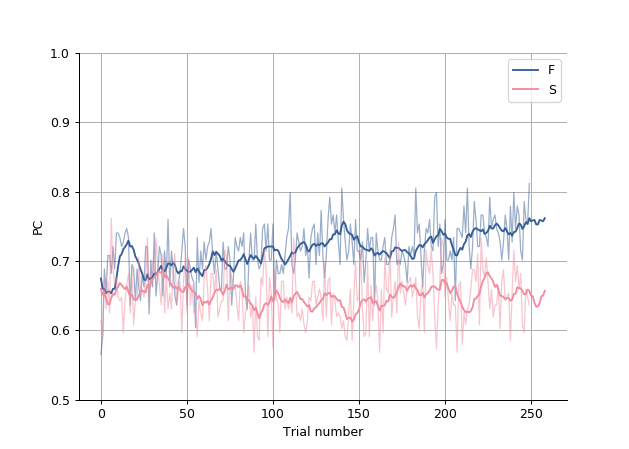

In [3]:
def free_play_pc(path, 
                 figname, save_to, save_as=None, compress=False,
                 show_raw=True, s=5, m='flat'):
    mdata = lut.unpickle(path)['main']

    sids, groups = lut.get_unique(mdata, [r.ix('sid'), r.ix('group')])

    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    fig = plt.figure(figname, figsize=[7,5])
    ax = fig.add_subplot(111)
    
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        cor = mdata[gmask, r.ix('cor')].reshape([gsids.size, -1])

        mean_pc = np.mean(cor, axis=0)

        ax.plot(vut.smooth(mean_pc, s, m), color=colors[grp], label=glabels[grp])
        if show_raw:
            ax.plot(mean_pc, color=colors[grp], alpha=.5, lw=1)
            
        
    ax.set_xlabel('Trial number')
    ax.set_ylabel('PC')
    ax.grid()
    ax.legend()
    ax.set_ylim(.5,1)
    vut.despine(ax, ['right', 'top'])
    
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    free_play_pc('pipeline_data/s3/joint_data.pkl',
                 'smoothed_pc_free', save_to=saveloc, save_as='', compress=True,
                 show_raw=True, s=10, m='flat')



## 11.2. During training (split by task)

<IPython.core.display.Javascript object>


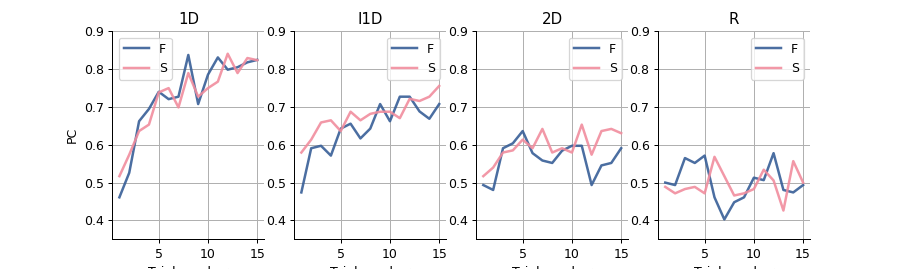

In [4]:
def train_pc(path, figname, save_to, save_as=None, compress=False):
    mdata = lut.unpickle(path)['main']

    sids, groups, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cat')])

    training = lut.get_mask(mdata, {r.ix('stage'): 0})
    mdata = mdata[training, :]
    mdata[:, r.ix('trial')] += 1
    
    fig = plt.figure(figname, figsize=[10,3])
    
    
    for tsk in tasks:
        ax = fig.add_subplot(1, 4, tsk)
        for grp in groups:
            gmask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('cat'): tsk})
            gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
            cor = mdata[gmask, r.ix('cor')].reshape([gsids.size, -1])

            mean_pc = np.mean(cor, axis=0)

            ax.plot(list(range(1,16)), mean_pc, color=colors[grp], alpha=.9, lw=2, label=glabels[grp])
            
        ax.set_title(tlabels[tsk])
        ax.set_xlabel('Trial number')
        if tsk==1: ax.set_ylabel('PC')
        ax.grid()
        ax.legend()
        ax.set_ylim(.35,.9)
        vut.despine(ax, ['right', 'top'])
    
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    train_pc('pipeline_data/s3/joint_data.pkl',
             'smoothed_pc_train', save_to=saveloc, save_as='', compress=True)

## 11.3. During free play with %select (split by task)

<IPython.core.display.Javascript object>


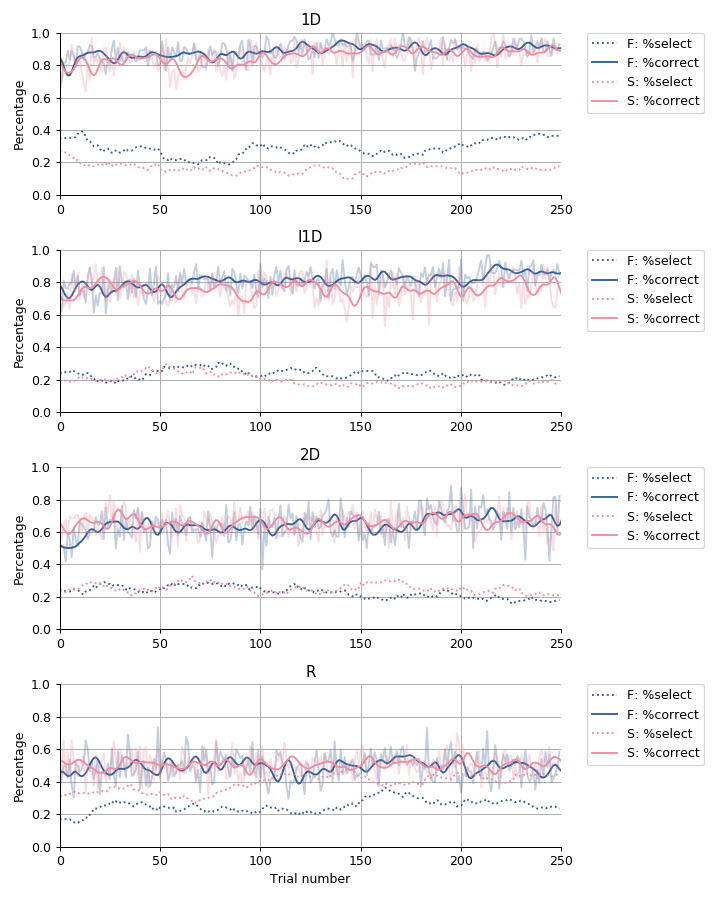

In [5]:
def free_play_pc2(path, 
                 figname, save_to, save_as=None, compress=False,
                 show_raw=True, s=5, m='flat'):
    mdata = lut.unpickle(path)['main']

    sids, groups, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cat')])

    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    fig = plt.figure(figname, figsize=[8,10])
    axes = {}
    for k,v in tlabels.items():
        axes[k] = fig.add_subplot(4,1,k)
    
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        cor = mdata[gmask, r.ix('cor')].reshape([gsids.size, -1])
        for tsk in tasks:
            tmask = np.array([mdata[gmask, r.ix('cat')] == tsk]).reshape([gsids.size, -1])
            psel = np.sum(tmask, axis=0) / gsids.size
            pcor = np.array([np.mean(cor[tmask[:, j], j]) for j in range(250)])
            axes[tsk].plot(psel, c=colors[grp], ls=':', label=glabels[grp]+': %select')
            axes[tsk].plot(pcor, c=colors[grp], alpha=.3)
            axes[tsk].plot(vut.smooth(pcor, 10), c=colors[grp], label=glabels[grp]+': %correct')
            
            axes[tsk].set_xlim(0,250)
            axes[tsk].set_ylim(0,1)
            axes[tsk].set_title(tlabels[tsk])
            axes[tsk].set_ylabel('Percentage')
            vut.despine(axes[tsk], ['right', 'top'])
            axes[tsk].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            axes[tsk].grid(True)
    axes[4].set_xlabel('Trial number')
            
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    free_play_pc2('pipeline_data/s3/joint_data.pkl',
                 'smoothed_pc_free2', save_to=saveloc, save_as='', compress=True,
                 show_raw=True, s=5, m='flat')

In [ ]:
def pswitch(path, 
                 figname, save_to, save_as=None, compress=False,
                 show_raw=True, s=5, m='flat'):
    mdata = lut.unpickle(path)['main']
    
    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0
    
    mdata[:-1, r.ix('switch')] = mdata[1:, r.ix('switch')]
    mdata[-1, r.ix('switch')] = 0
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    sids, groups = lut.get_unique(mdata, [r.ix('sid'), r.ix('group')])
    
    fig = plt.figure(figname, figsize=[7,5])
    ax = fig.add_subplot(111)
    
    x = np.arange(1,251)
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        switch = mdata[gmask, r.ix('switch')].reshape([gsids.size, -1])

        mean_pc = np.sum(switch, axis=0)/gsids.size

        ax.plot(x, vut.smooth(mean_pc, s, m)[(s//2-1):-(s//2)], 
                color=colors[grp], label=glabels[grp])
        if show_raw:
            ax.plot(x, mean_pc, color=colors[grp], alpha=.5, lw=1)
            
    print(mean_pc.shape, vut.smooth(mean_pc, s, m).shape)    
    ax.set_xlabel('Trial number')
    ax.set_ylabel('Pr(switch)')
    ax.grid()
    ax.legend()
#     ax.set_ylim(.5,1)
    vut.despine(ax, ['right', 'top'])
    
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    pswitch('pipeline_data/s3/joint_data.pkl',
             'pr_switch', save_to=saveloc, save_as='', compress=True,
             show_raw=1, s=10)

# 12. Individual level task selection

## 12.1. Histograms (time spent on each task)

<IPython.core.display.Javascript object>


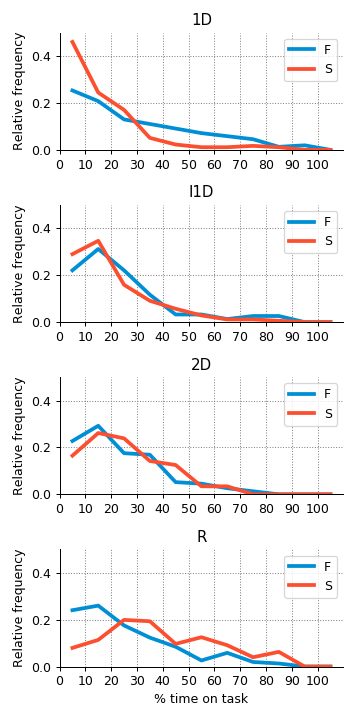

In [8]:
def ind_task_selection(path, figname, save_to=None, save_as=None, compress=True):
    data = lut.unpickle(path)['main']

    G, T, S = [r.ix(x) for x in ('group', 'cat', 'sid')]
    groups, tasks, sids = lut.get_unique(data, [G, T, S])
    
    freeplay = lut.get_mask(data, {r.ix('stage'): 1})
    data = data[freeplay, :]
    data[:, r.ix('trial')] -= 60
    
    by_group = {}
    for grp in groups:
        gmask = lut.get_mask(data, {G: grp})
        gsids = lut.get_unique(data[gmask,:], S)
        
        by_group[grp] = {1:[],2:[],3:[],4:[]}
        for sid in gsids:
            mask = lut.get_mask(data, {S: sid})
            subj_tasks, counts = np.unique(data[mask, T], return_counts=True)
            proportions = counts / np.sum(counts)
            
            for tsk in tasks:
                by_group[grp][tsk].append(
                    proportions[np.where(subj_tasks==tsk)][0] if tsk in subj_tasks else 0
                )
    
    fig = plt.figure(num=figname, figsize=[4,8])
    
    for tsk in tasks:
        ax = fig.add_subplot(4, 1, tsk)
        ax.set_title(tlabels[tsk])
        if tsk == 4: ax.set_xlabel('% time on task')
        ax.set_ylabel('Relative frequency')
        ax.set_ylim(0,.5)
        for grp in groups:
            vut.line_histogram(ax, np.array(by_group[grp][tsk])*100, 
                               bins=np.arange(0,120,10), 
                               label=glabels[grp],
                               c=gcolors[grp], lw=3)
        ax.legend()
        
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)
    
if 1:
    ind_task_selection(
        path='pipeline_data/s3/joint_data.pkl',
        figname='histograms of time spent on each task'.replace(' ', '_'),
        save_to=saveloc,
        save_as=''
    )

## 12.2. Identifying different task selection styles (radar plots)

In [ ]:
def ind_task_selection2(path, figname, save_to=None, save_as=None, compress=True):
    data = lut.unpickle(path)['main']

    G, T, S = [r.ix(x) for x in ('group', 'cat', 'sid')]
    groups, tasks, sids = lut.get_unique(data, [G, T, S])
    
    freeplay = lut.get_mask(data, {r.ix('stage'): 1})
    data = data[freeplay, :]
    data[:, r.ix('trial')] -= 60
    
    by_group = {}
    for grp in groups:
        gmask = lut.get_mask(data, {G: grp})
        gsids = lut.get_unique(data[gmask,:], S)
        
        by_group[grp] = {1:[],2:[],3:[],4:[]}
        for sid in gsids:
            mask = lut.get_mask(data, {S: sid})
            subj_tasks, counts = np.unique(data[mask, T], return_counts=True)
            proportions = counts / np.sum(counts)
            
            for tsk in tasks:
                by_group[grp][tsk].append(
                    proportions[np.where(subj_tasks==tsk)][0] if tsk in subj_tasks else 0
                )
    
    fig = plt.figure(num=figname, figsize=[10,5])
    
    weird_order = [2,1,4,3]
    gdata = {
        0: np.stack([by_group[0][tsk] for tsk in weird_order], axis=1)*100,
        1: np.stack([by_group[1][tsk] for tsk in weird_order], axis=1)*100}
    task_labels = [tlabels[tsk] for tsk in weird_order]
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [(n / float(tasks.size) * 2 * np.pi) + np.pi/tasks.size for n in range(tasks.size)]
    angles += angles[:1]

    for grp in groups:
        # Initialise the spider plot
        ax = plt.subplot(1,2,grp+1, polar=True)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], task_labels, color='grey', size=12)

        # Draw ylabels
        ax.set_rlabel_position(0)
        y = np.arange(0,101, 20)
        plt.yticks(y, [str(y_) for y_ in y], color="grey", size=7)
        plt.ylim(0,100)
        plt.grid(axis='x')

        # Plot data
        y = np.concatenate([gdata[grp], gdata[grp][:,0].reshape(-1,1)], axis=1)
        ax.plot(angles, y.T, linewidth=.5, alpha=.1, color='k')

        # Fill area
        # ax.fill(angles, y.T, 'b', alpha=0.01, color=colors[grp])
        
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)
    
if 0:
    ind_task_selection2(
        path='pipeline_data/s3/joint_data.pkl',
        figname='time spent on each task radar plots lines'.replace(' ', '_'),
        save_to=saveloc,
        save_as=''
    )

## 12.3. Task selection (allocation variance)

<IPython.core.display.Javascript object>


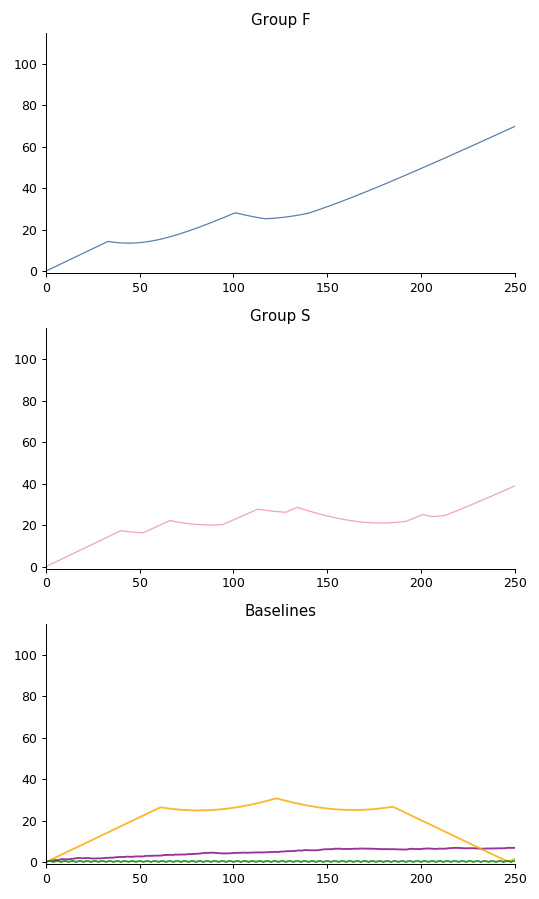

In [6]:
def ind_task_selection3(path, figname, save_to=None, save_as=None, compress=True):
    data = lut.unpickle(path)['main']

    G, T, S = [r.ix(x) for x in ('group', 'cat', 'sid')]
    groups, tasks, sids = lut.get_unique(data, [G, T, S])
    
    freeplay = lut.get_mask(data, {r.ix('stage'): 1})
    data = data[freeplay, :]
    data[:, r.ix('trial')] -= 61
    
    fig = plt.figure(num=figname, figsize=[6,10])
    
    YLIM = [-1, 115]
    XLIM = [0, 250]
    
    for grp in groups:
        ax = fig.add_subplot(3,1,grp+1)
        ax.set_title('Group {}'.format(glabels[grp]))
        ax.set_ylim(YLIM)
        ax.set_xlim(XLIM)
        vut.despine(ax, ['top', 'right'])
        
        gmask = lut.get_mask(data, {G: grp})
        gsids = lut.get_unique(data[gmask,:], S)
        
        for sid in gsids[:1]:
            mask = lut.get_mask(data, {S: sid})
            
            choices = np.stack([
                lut.get_mask(data[mask, :], {T: tsk}).astype(int) for tsk in tasks
            ], axis=1)
            
            count_hist = np.cumsum(
                np.concatenate([np.zeros([1, 4]), choices], axis=0), 
                axis=0
            ).astype(int)

            alloc_traj = np.std(count_hist, axis=1)
    
            ax.plot(alloc_traj, alpha=.8, color=colors[grp], lw=1)
            
    

    bax = fig.add_subplot(3,1,3)
    bax.set_title('Baselines')
    bax.set_ylim(YLIM)
    bax.set_xlim(XLIM)
    vut.despine(bax, ['top', 'right'])
    
    random_baseline = []
    for i in range(10):
        totally_random = np.zeros([251,4])
        totally_random[np.arange(1,251),np.random.randint(0,4,250)] = 1
        random_baseline.append(np.std(np.cumsum(totally_random, axis=0), axis=1))

    
    bax.plot(
        np.mean(np.stack(random_baseline, axis=1), axis=1),
        color='purple',
        alpha=.8
    )
    
    min_explor = np.zeros([251,4])
    q = 250//4
    min_explor[1:q,0] = 1
    min_explor[q:q*2,1] = 1
    min_explor[q*2:q*3,2] = 1
    min_explor[q*3:,3] = 1

    bax.plot(
            np.std(np.cumsum(min_explor, axis=0), axis=1),
            color='orange',
            alpha=.8
        )
    
    max_explor = np.zeros_like(min_explor)
    max_explor[np.arange(1,251), np.tile([0,1,2,3],63)[:250]] = 1
    bax.plot(
        np.std(np.cumsum(max_explor, axis=0), axis=1),
        color='green',
        alpha=.8
    )
    
    fig.tight_layout()
    
if 1:
    ind_task_selection3(
        path='pipeline_data/s3/joint_data.pkl',
        figname='alloc var trajectories'.replace(' ', '_'),
        save_to=saveloc,
        save_as=''
    )

# 13. Task stickiness relationships

In [ ]:
def task_stickiness(path, 
                 figname, save_to, save_as=None, compress=False,
                 show_raw=True, s=5, m='flat'):
    mdata = lut.unpickle(path)['main']

    sids, groups, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cat')])
    
    mdata[:, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    stickiness = {}
    train_pc_task = {}
    train_pc_rest = {}
    free_pc_task = {}
#     free_pc_rest = {}
    
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        n = gsids.size
        
        stickiness[grp] = {1:[], 2:[], 3:[], 4:[]}
        train_pc_task[grp] = {1:[], 2:[], 3:[], 4:[]}
        free_pc_task[grp] = {1:[], 2:[], 3:[], 4:[]}
        
        for sid in gsids:
            freeplay = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1})
            training = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 0})
            
            subj_tasks, counts = np.unique(mdata[freeplay, r.ix('cat')], return_counts=True)
            if subj_tasks.size < 4: continue
            train = mdata[training, :]
            free = mdata[freeplay, :]
            counts = counts / np.sum(counts)
            for tsk in tasks:                
                stickiness[grp][tsk].append(
                    counts[np.where(subj_tasks==tsk)][0] if tsk in subj_tasks else 0
                )
                
                train_pc_task[grp][tsk].append(
                    np.mean(
                        train[lut.get_mask(train, {r.ix('cat'): tsk}), r.ix('cor')][-10:]
                    )
                )
                
                free_pc_task[grp][tsk].append(
                    np.mean(
                        free[lut.get_mask(free, {r.ix('cat'): tsk}), r.ix('cor')]
                    )
                )

    
    for grp in groups:
        fig = plt.figure(num='stickiness and pc {}'.format(glabels[grp]), figsize=[8.2,8.2])
        gs = mpl.gridspec.GridSpec(4, 4)
        for ytsk in tasks:
            for xtsk in tasks:
                ax = fig.add_subplot(gs[ytsk-1, xtsk-1])

                x = free_pc_task[grp][xtsk]
                y = stickiness[grp][ytsk]
                
                rho = pearsonr(x,y)
                
                ax.text(0.1, 0.9, 'r = {:.3f}\np = {:.4f}'.format(rho[0], rho[1]), 
                     ha='left', va='top', transform=ax.transAxes, color='k' if rho[1] < .025 else 'gray')

                ax.scatter(x, y, alpha=.4,
                           marker='o', s=10, color=colors[grp])
                x = sm.add_constant(x)
                model = sm.OLS(y, x)
                results = model.fit()
                ax.plot(np.array([-.1, 1.1]), 
                    results.params[0] + np.array([-.1, 1.1])*results.params[1],
                    lw=1, c=colors[grp])

                
                ax.set_xlim(-.1,1.1)
                ax.set_ylim(-.1,1.1)

                if ytsk < 4:
                    ax.tick_params(direction='in', labelbottom=False)
                if xtsk > 1:
                    ax.tick_params(direction='in', labelleft=False)

                if ytsk == 4:
                    ax.tick_params(direction='out', labelbottom=True)
                    ax.set_xlabel('{}\n%correct'.format(tlabels[xtsk]))
                if xtsk == 1:
                    ax.set_ylabel('{}\n%select'.format(tlabels[ytsk]))
                    ax.tick_params(direction='out', labelleft=True)

        fig.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)
        if save_as:
            save_it(fig, save_to, '{}_{}'.format(figname, glabels[grp]), save_as, compress=compress)
if 1:
    task_stickiness('pipeline_data/s3/joint_data.pkl',
                    'stickiness and pc'.replace(' ', '_'), 
                    save_to=saveloc, 
                    save_as='', 
                    compress=True)

# 14. Clustering

In [ ]:
def prep_data(path):
    mdata = lut.unpickle(path)['main']

    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata[freeplay, r.ix('trial')] -= 60

    nonfree = lut.get_mask(mdata, {r.ix('stage'): 1}, '!=')
    mdata[nonfree, r.ix('switch')] = 0

    mdata[:-1, r.ix('switch')] = mdata[:, r.ix('switch')][1:]
    mdata[-1, r.ix('switch')] = 0

    groups, conds, tasks = lut.get_unique(mdata, [r.ix('group'), 
                                                  r.ix('cond'), 
                                                  r.ix('cat')])

    outdata = {}
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        n = gsids.size

        outdata[grp] = []
        for sid in gsids:
            subj_features = []

            freeplay = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1})
            training = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 0})

            subj_tasks, counts = np.unique(mdata[freeplay, r.ix('cat')], return_counts=True)
            counts = counts / np.sum(counts)

            for tsk in tasks:                
                subj_features.append(
                    counts[np.where(subj_tasks==tsk)][0] if tsk in subj_tasks else 0
                )

            subj_features.append(
                np.sum(mdata[freeplay, r.ix('switch')]).astype(int)
            )
            
            outdata[grp].append(subj_features)


    for k, v in outdata.items():
        outdata[k] = np.array(v)
    
    outdata = np.concatenate([outdata[grp] for grp in groups])
    
    return outdata


def cluster(data):
    clf = KMeans(n_clusters=2)
    clf.fit(data)
    
    centroids = clf.cluster_centers_
    labels = clf.labels_

    fig = plt.figure(num='clusters', figsize=[10,5])
    
    weird_order = [2,1,4,3]
    gdata = {
        0: data[np.where(labels==0),:-1]*100,
        1: data[np.where(labels==0),:-1]*100}
    task_labels = [tlabels[tsk] for tsk in weird_order]
    print(gdata)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [(n / float(4) * 2 * np.pi) + np.pi/4 for n in range(4)]
    angles += angles[:1]

    for c in labels:
        # Initialise the spider plot
        ax = plt.subplot(1,2,c+1, polar=True)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], task_labels, color='grey', size=12)

        # Draw ylabels
        ax.set_rlabel_position(0)
        y = np.arange(0,101, 20)
        plt.yticks(y, [str(y_) for y_ in y], color="grey", size=7)
        plt.ylim(0,100)
        plt.grid(axis='x')

        # Plot data
        y = np.concatenate([gdata[c], gdata[c][:,0].reshape(-1,1)], axis=1)
        ax.plot(angles, y.T, linewidth=.5, alpha=.1, color='k')
        ax.fill(angles, y.T, 'b', alpha=0.01, color=colors[c])

if 0: 
    data = prep_data('pipeline_data/s3/joint_data.pkl')
    # cluster(data)
    

# 15. Selection rates

## 15.0. Prepare data

In [ ]:
def prepare_selection_data(path, pickle_path=None):
    
    mdata, xdata = [lut.unpickle(path)[k] for k in ['main', 'extra']]

    sids, groups, tasks, monsters = lut.get_unique(mdata, [r.ix('sid'), 
                                                           r.ix('group'), 
                                                           r.ix('cat'),
                                                           r.ix('fam')])
    monsters = monsters.tolist()
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})

    mdata[freeplay, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    outdata = []
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        n = gsids.size
        
        for sid in gsids:
            freemask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 1})
            trainmask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 0})
            
            subj_tasks, counts = np.unique(mdata[freemask, r.ix('cat')], return_counts=True)
            
#             remove outliers who didn't play each task at least 5 times
#             if counts.size < 4:
#                 print(sid, '- didn\'t play all 4: {}'.format(counts))
#                 continue
#             if any([i<5 for i in counts]):
#                 print(sid, '- played less than 5: {}'.format(counts))
#                 continue
                
            # cols 0:2 = sid and group
            features = [sid, grp]
            
            train = mdata[trainmask, :]
            free = mdata[freemask, :]
            counts = counts / np.sum(counts)
#             z = lambda x: (x-np.mean(train[:,r.ix('cor')]))/np.std(train[:,r.ix('cor')])
            for tsk in tasks:
                # cols 2:6 = selection rates
                features.append(
                    counts[np.where(subj_tasks==tsk)][0] if tsk in subj_tasks else 0
                )
            
            for tsk in tasks:
                # cols 6:10 = train pc
                mask = lut.get_mask(train, {r.ix('cat'): tsk})
                features.append(np.mean(train[mask, r.ix('cor')]))
#                 features.append(z(np.mean(train[mask, r.ix('cor')])))
            
            for tsk in tasks:
                # cols 10:14 = free pc (or test)
                mask = lut.get_mask(free, {r.ix('cat'): tsk})
                features.append(
                    np.mean(free[mask, r.ix('cor')]) if np.any(mask) else np.nan
                )
            
            for tsk in tasks:
                # cols 14:18 = test pc (or test)
                mask = lut.get_mask(free, {r.ix('cat'): tsk})
                features.append(
                    np.mean(free[mask, r.ix('cor')][-5:]) if np.any(mask) else np.nan
                )
                
            for tsk in tasks:
                # cols 18:42 = LRN ratings
                mask = lut.get_mask(train, {r.ix('cat'): tsk})
                mi = monsters.index(train[mask, r.ix('fam')][0])

                mask = lut.get_mask(xdata, {r.ix('sid'): sid})
                features.append(xdata[mask, rx.ix('q6m1') + mi * 7][0].astype(int))
            
            for q in [1,2,3,4,5,7]:
                for tsk in tasks:
                    # cols 42:46 = questions
                    mask = lut.get_mask(train, {r.ix('cat'): tsk})
                    mi = monsters.index(train[mask, r.ix('fam')][0])                    
                    
                    mask = lut.get_mask(xdata, {r.ix('sid'): sid})
                    features.append(xdata[mask, rx.ix('q{}m1'.format(q)) + mi * 7][0].astype(int))
                
             # col 47: allocation variance   
            features.append(np.std(counts))
            
            outdata.append(features)

    outdata = np.array(outdata)
    A = ['sid', 'grp']
    B = ['ps_{}'.format(t) for t in tasks]
    C = ['pct_{}'.format(t) for t in tasks]
    D = ['pcf_{}'.format(t) for t in tasks]
    D1 = ['pctst_{}'.format(t) for t in tasks]
    E = ['lrn_{}'.format(t) for t in tasks]
    F = ['int_{}'.format(t) for t in tasks]
    G = ['comp_{}'.format(t) for t in tasks]
    H = ['time_{}'.format(t) for t in tasks]
    I = ['prog_{}'.format(t) for t in tasks]
    J = ['rule_{}'.format(t) for t in tasks]
    K = ['lrn2_{}'.format(t) for t in tasks]
    L = ['alv']
    
    cols = [*A, *B, *C, *D, *D1, *E, *F, *G, *H, *I, *K, *L]
    
#     lut.print_arr(outdata,
#                  cols=[*A, *B, *C, *D, *E, *F],
#                  nonints=[*B, *C, *D, *F],
#                  round_=2, pretty=True)
    
    if pickle_path:
        lut.dopickle(pickle_path, outdata)
        return pickle_path
    else:
        return outdata
    
if 1: prepare_selection_data(path=data_path,
                   pickle_path='pipeline_data/selection_rates/data_v3.pkl')

## 15.1. Distributions

In [ ]:
def selection_rates(path, save_as=''):
    plt.figure('Selection rates for different subgroups', figsize=[4,9])
    
    mdata = lut.unpickle(path)['main']
    labels = [tlabels[l] for l in [1,2,3,4]]

    plt.subplot(4,1,1)
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    tasks, popularity = np.unique(mdata[freeplay, r.ix('cat')], return_counts=1)

    plt.plot(tasks, popularity/np.sum(popularity), lw=2, c='k')
    plt.xticks(tasks, labels)
    plt.ylim(.1,.4)
    plt.ylabel('Proportion of trials')
    plt.title('Overall')
    plt.grid(True, axis='y')
    vut.despine(plt.gca(), ['top', 'right'])
    
    plt.subplot(4,1,2)
    for cnd in [0,1]:
        freeplay = lut.get_mask(mdata, {r.ix('stage'): 1, r.ix('cond'): cnd})
        tasks, popularity = np.unique(mdata[freeplay, r.ix('cat')], return_counts=1)

        plt.plot(tasks, popularity/np.sum(popularity), color=gcolors[cnd], lw=2, label=clabels[cnd])
        plt.xticks(tasks, labels)
        plt.title('Split by condition')
    plt.ylim(.1,.4)
    plt.ylabel('Proportion of trials')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, axis='y')
    vut.despine(plt.gca(), ['top', 'right'])    
    
    plt.subplot(4,1,3)
    for grp in [0,1]:
        freeplay = lut.get_mask(mdata, {r.ix('stage'): 1, r.ix('group'): grp})
        tasks, popularity = np.unique(mdata[freeplay, r.ix('cat')], return_counts=1)

        plt.plot(tasks, popularity/np.sum(popularity), color=gcolors[grp], lw=2, label=glabels[grp])
        plt.xticks(tasks, labels)
        plt.title('Split  by group')
    plt.ylim(.1,.4)
    plt.ylabel('Proportion of trials')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, axis='y')
    vut.despine(plt.gca(), ['top', 'right'])
    
    plt.subplot(4,1,4)
    for grp in [0,1]:
        for cnd in [0,1]:
            freeplay = lut.get_mask(mdata, {r.ix('stage'): 1, 
                                            r.ix('group'): grp, 
                                            r.ix('cond'): cnd})
            tasks, popularity = np.unique(mdata[freeplay, r.ix('cat')], return_counts=1)
            plt.plot(tasks, popularity/np.sum(popularity), color=gcolors[grp], ls='--' if not cnd else '-', lw=2, label=glabels[grp]+'/'+clabels[cnd])
            plt.xticks(tasks, labels)
    plt.ylim(.1,.4)
    plt.ylabel('Proportion of trials')
    plt.xlabel('Task')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('2-way split')
    plt.grid(True, axis='y')
    vut.despine(plt.gca(), ['top', 'right'])
    
    plt.tight_layout()

    if save_as:
        save_it(plt.gcf(), saveloc, 'time_on_tasks', save_as='svg')
    
if 1: 
    selection_rates('pipeline_data/s3/joint_data.pkl', 'svg')

## 15.1.1. Time and switches

In [ ]:
def timeVswitches(path, save_as='svg'):
    plt.figure('Relative time spent on task and switch proportions', figsize=[7,3])
    
    mdata = lut.unpickle(path)['main']
    mdata[mdata[:, r.ix('trial')]<=61, r.ix('switch')] = 0
#     lut.print_arr(mdata, cols=r.cols)
    
    labels = [tlabels[l] for l in [1,2,3,4]]
    leg = ['Trials', 'Switches']
    
    for i in [0,1]:
        plt.subplot(1,2,1)
        freeplay = lut.get_mask(mdata, {r.ix('stage'): 1, r.ix('group'): 0})
        smask = lut.get_mask(mdata, {r.ix('switch'): i})
        if not i: smask = np.ones_like(smask).astype(bool)
        tasks, popularity = np.unique(mdata[freeplay & smask, r.ix('cat')], 
                                      return_counts=1)

        plt.plot(tasks, popularity/np.sum(popularity), lw=2, c=gcolors[i], 
                 label=leg[i])
        plt.xticks(tasks, labels)
        plt.ylim(.1,.4)
        plt.ylabel('Proportion')
        plt.legend()

        plt.title('Free')
        print('Free {}: {}'.format(leg[i].lower(), popularity/np.sum(popularity)))
        plt.grid(True, axis='y')
        vut.despine(plt.gca(), ['top', 'right'])

        
        plt.subplot(1,2,2)
        freeplay = lut.get_mask(mdata, {r.ix('stage'): 1, r.ix('group'): 1})
        smask = lut.get_mask(mdata, {r.ix('switch'): i})
        if not i: smask = np.ones_like(smask).astype(bool)
        tasks, popularity = np.unique(mdata[freeplay & smask, r.ix('cat')], 
                                      return_counts=1)

        plt.plot(tasks, popularity/np.sum(popularity), 
                 color=gcolors[i], lw=2, label=leg[i])
        plt.xticks(tasks, labels)
        plt.title('Strategic')
        plt.ylim(.1,.4)
        plt.ylabel('Proportion')
        plt.grid(True, axis='y')
        vut.despine(plt.gca(), ['top', 'right'])
        plt.legend()
        print('Strategic {}: {}'.format(leg[i].lower(), popularity/np.sum(popularity)))
        

    plt.tight_layout()
    if save_as:
        save_it(plt.gcf(), saveloc, 'time_vs_switching', save_as='svg')

if 1: 
    timeVswitches('pipeline_data/s3/joint_data.pkl', save_as='svg')

## 15.2. Stickiness and PC

In [ ]:
def against_iv(data_or_path, figname,
               iv,
               xlim,
               xlabel,
               save_to='', 
               save_as='', 
               compress=True):
    
    if isinstance(data_or_path, str):
        data = lut.unpickle(data_or_path)
    else:
        data = data_or_path
    
    groups = [0,1]
    tasks = [1,2,3,4]
    
    A = ['sid', 'grp']
    B = ['ps_{}'.format(t) for t in tasks]
    C = ['pct_{}'.format(t) for t in tasks]
    D = ['pcf_{}'.format(t) for t in tasks]
    D1 = ['pctst_{}'.format(t) for t in tasks]
    E = ['lrn_{}'.format(t) for t in tasks]
    F = ['int_{}'.format(t) for t in tasks]
    G = ['comp_{}'.format(t) for t in tasks]
    H = ['time_{}'.format(t) for t in tasks]
    I = ['prog_{}'.format(t) for t in tasks]
    J = ['rule_{}'.format(t) for t in tasks]
    K = ['lrn2_{}'.format(t) for t in tasks]
    L = ['alv']
    
    cols = [*A, *B, *C, *D, *D1, *E, *F, *G, *H, *I, *J, *K, *L]
    ix = cols.index
    
    fig = plt.figure(num=figname, figsize=[5,8])
    gs = mpl.gridspec.GridSpec(4, 2)
    
    for grp in groups:
        mask = lut.get_mask(data, {ix('grp'): grp})
#         plt.plot(np.sum(data[mask, 2:6], axis=0))
        for ti, tsk in enumerate(tasks):
            ax = fig.add_subplot(gs[ti, grp])

            x = data[mask, ix('{}_{}'.format(iv, tsk))]
            y = data[mask, ix('ps_{}'.format(tsk))]

            rho = pearsonr(x,y)

            ax.text(0.1, 0.9, 'r = {:.3f}\np = {:.4f}'.format(rho[0], rho[1]), 
                 ha='left', va='top', transform=ax.transAxes, color='k' if rho[1] < .025 else 'gray')

            ax.scatter(x, y, alpha=.4,
                       marker='o', s=5, color=colors[grp])
            x = sm.add_constant(x)
            model = sm.OLS(y, x)
            results = model.fit()
            linex, liney = xlim
            ax.plot(np.array([linex, liney]), 
                results.params[0] + np.array([linex, liney])*results.params[1],
                lw=1, c=colors[grp])

            ax.set_xlim(xlim)
            ax.set_ylim(-.1, 1)

            if ti == 0:
                ax.set_title('Group {}'.format(glabels[grp]))
            
            if ti == 3:
                ax.tick_params(axis='x', direction='out', labelbottom=True)
                ax.set_xlabel(xlabel)
            else:
                ax.tick_params(axis='x', direction='in', labelbottom=False)
            
            if grp: 
                ax.tick_params(axis='y', direction='in', labelleft=False)
            else:
                ax.set_ylabel('Time spent on\n{} (%select)'.format(tlabels[tsk]))
                ax.tick_params(axis='y', direction='out', labelleft=True)            
                    
        fig.tight_layout()
        fig.subplots_adjust(wspace=0.05, hspace=0.05)
        
    if save_as:
        save_it(fig, save_to, figname, save_as, compress=compress)
    
if 1:
    path = 'pipeline_data/selection_rates/data.pkl'
#     prepare_data(data_path, pickle_path=None)
    against_iv(
        data_or_path=path,
        figname='stickiness and rpc train'.replace(' ', '_'), 
        iv='pct',
        xlim=(.25, 1),
        xlabel='PC training\n(mean of other 3 tasks)',
        save_to=saveloc, 
        save_as='svg', 
        compress=True)
    
    against_iv(
        data_or_path=path,
        figname='stickiness and rpc free'.replace(' ', '_'),
        iv='pcf',
        xlim=(.25, 1),
        xlabel='PC free play\n(mean of other 3 tasks)',
        save_to=saveloc, 
        save_as='svg', 
        compress=True)

## 15.3. Stickiness and subjective ratings

In [ ]:
def against_sr(data_or_path, figname,
               iv,
               xlim,
                xlabel,
               save_to='', 
               save_as='', 
               compress=True):
    
    if isinstance(data_or_path, str):
        data = lut.unpickle(data_or_path)
    else:
        data = data_or_path
    
    groups = [0,1]
    tasks = [1,2,3,4]
    
    A = ['sid', 'grp']
    B = ['ps_{}'.format(t) for t in tasks]
    C = ['pct_{}'.format(t) for t in tasks]
    D = ['pcf_{}'.format(t) for t in tasks]
    E = ['lrn_{}'.format(t) for t in tasks]
    F = ['int_{}'.format(t) for t in tasks]
    G = ['comp_{}'.format(t) for t in tasks]
    H = ['time_{}'.format(t) for t in tasks]
    I = ['prog_{}'.format(t) for t in tasks]
    J = ['rule_{}'.format(t) for t in tasks]
    K = ['lrn2_{}'.format(t) for t in tasks]
    L = ['alv']
    
    cols = [*A, *B, *C, *D, *E, *F, *G, *H, *I, *J, *K, *L]
    ix = cols.index
    
    fig = plt.figure(num=figname, figsize=[6.7,10])
    gs = mpl.gridspec.GridSpec(5, 2)
    
    _max, hax = 0, []
    for grp in groups:
        mask = lut.get_mask(data, {ix('grp'): grp})
#         plt.plot(np.sum(data[mask, 2:6], axis=0))
        hax.append(fig.add_subplot(gs[-1, grp]))
        
        for ti, tsk in enumerate(tasks):
            ax = fig.add_subplot(gs[ti, grp])
            vut.despine(ax, ['right', 'top'])
            
            x = data[mask, ix('{}_{}'.format(iv, tsk))]
            y = data[mask, ix('ps_{}'.format(tsk))]

            rho = pearsonr(x,y)

            ax.text(0.1, 0.9, 'r = {:.3f}\np = {:.4f}'.format(rho[0], rho[1]), 
                 ha='left', va='top', transform=ax.transAxes, color='k' if rho[1] < .025 else 'gray')
            
            means = [np.mean(y[np.where(x ==r)]) for r in list(range(1,11))]
            ax.scatter(x, y, alpha=.4,
                       marker='_', s=5, color=colors[grp])
            
            ax.plot(list(range(1,11)), means, color='k',
                   ls='', marker='+', markersize=5)
            
            x = sm.add_constant(x)
            model = sm.OLS(y, x)
            results = model.fit()
            if xlim:
                lower, upper = xlim 
            else: lower, upper = np.min(x[:,1]), np.max(x[:,1])
            
            ax.plot(np.array([lower, upper]), 
                results.params[0] + np.array([lower, upper])*results.params[1],
                lw=1, c=colors[grp])

            if xlim: ax.set_xlim(xlim)
            ax.set_ylim(-.1, 1)

            if ti == 0:
                ax.set_title('Group {}'.format(glabels[grp]))
            
            if grp == 0: 
                ax.set_ylabel('Time spent on\n{} (%select)'.format(tlabels[tsk]))      

            dynmax = vut.line_histogram(hax[-1], x[:,1], bins=[1,2,3,4,5,6,7,8,9,10,11], 
                               label=tlabels[tsk], c=colors[ti], lw=2)
            if np.max(dynmax) > _max: _max = np.max(dynmax)
            hax[-1].legend(bbox_to_anchor=(0,1,1,0.2), loc='upper left', mode='expand', ncol=4)
            
            hax[-1].set_xlabel(xlabel)
            
    for grp in groups:
        hax[grp].set_ylim([0, _max + _max/5])
        hax[grp].set_xlim(xlim)
        if grp==0:
            hax[grp].set_ylabel('Relative frequency')
        
        fig.tight_layout()
#         fig.subplots_adjust(wspace=0.05, hspace=0.05)
        
    if save_as:
        save_it(fig, save_to, figname, save_as, compress=compress)

            
if 1:
    ivs = {
        'lrn' :'Learnability 1',
        'lrn2':'Learnability 2',
        'int' :'Interest',
        'comp':'Complexity',
        'time':'Subjective time',
        'prog':'Progress',
        'rule':'Rule',
    }
    
    for k,v in ivs.items():
        against_sr(
            data_or_path='pipeline_data/selection_rates/data.pkl',
            figname='stickiness and subj {}'.format(k).replace(' ', '_'),
            iv=k,
            xlabel=v,
            xlim=(.5,11),
            save_to=saveloc, 
            save_as='svg', 
            compress=True)

## 15.4. Stickiness and allocation variance

In [ ]:
def against_alv(data_or_path, figname,
               iv,
               xlim,
                xlabel,
               save_to='', 
               save_as='', 
               compress=True):
    
    if isinstance(data_or_path, str):
        data = lut.unpickle(data_or_path)
    else:
        data = data_or_path
    
    groups = [0,1]
    tasks = [1,2,3,4]
    
    A = ['sid', 'grp']
    B = ['ps_{}'.format(t) for t in tasks]
    C = ['pct_{}'.format(t) for t in tasks]
    D = ['pcf_{}'.format(t) for t in tasks]
    E = ['lrn_{}'.format(t) for t in tasks]
    F = ['int_{}'.format(t) for t in tasks]
    G = ['comp_{}'.format(t) for t in tasks]
    H = ['time_{}'.format(t) for t in tasks]
    I = ['prog_{}'.format(t) for t in tasks]
    J = ['rule_{}'.format(t) for t in tasks]
    K = ['lrn2_{}'.format(t) for t in tasks]
    L = ['alv']
    
    cols = [*A, *B, *C, *D, *E, *F, *G, *H, *I, *J, *K, *L]
    ix = cols.index
    
    fig = plt.figure(num=figname, figsize=[6.7,10])
    gs = mpl.gridspec.GridSpec(4, 2)
    
    for grp in groups:
        mask = lut.get_mask(data, {ix('grp'): grp})
        for ti, tsk in enumerate(tasks):
            ax = fig.add_subplot(gs[ti, grp])
            vut.despine(ax, ['right', 'top'])
            
            x = data[mask, ix('{}'.format(iv))]
            y = data[mask, ix('ps_{}'.format(tsk))]

            rho = pearsonr(x,y)

            ax.text(0.1, 0.9, 'r = {:.3f}\np = {:.4f}'.format(rho[0], rho[1]), 
                 ha='left', va='top', transform=ax.transAxes, color='k' if rho[1] < .025 else 'gray')
            
            ax.scatter(x, y, alpha=.4,
                       marker='o', s=5, color=colors[grp])
            
            x = sm.add_constant(x)
            model = sm.OLS(y, x)
            results = model.fit()
            if xlim:
                lower, upper = xlim 
            else: lower, upper = np.min(x[:,1]), np.max(x[:,1])
            
            ax.plot(np.array([lower, upper]), 
                results.params[0] + np.array([lower, upper])*results.params[1],
                lw=1, c=colors[grp])

            if xlim: ax.set_xlim(xlim)
            ax.set_ylim(-.1, 1)

            if ti == 0:
                ax.set_title('Group {}'.format(glabels[grp]))
            
            if grp == 0: 
                ax.set_ylabel('Time spent on\n{} (%select)'.format(tlabels[tsk]))      

            if ti == 3:
                ax.set_xlabel(xlabel)
            
        fig.tight_layout()
        
    if save_as:
        save_it(fig, save_to, figname, save_as, compress=compress)

            
if 1:
    against_alv(
        data_or_path='pipeline_data/selection_rates/data.pkl',
        figname='stickiness and alv'.replace(' ', '_'),
        iv='alv',
        xlabel='Allocation variance',
        xlim=None,
        save_to=saveloc, 
        save_as='svg', 
        compress=True)

## 15.4. Stickiness and dPC

In [ ]:
def stickiness_and_dPC(
            path, xlim=None,
            figname='stickiness and alv'.replace(' ', '_'),
            save_to=saveloc,
            save_as='',
            compress=True):
    # model with PC test and deltaPC uses 57 less participants 
    # (those who played all tasks and at least 5 trials on each task)
    # so perhaps we are looking at a differernt population here?
    
    data = lut.unpickle(path)
    
    groups = [0,1]
    tasks = [1,2,3,4]
    
    A = ['sid', 'grp']
    B = ['ps_{}'.format(t) for t in tasks]
    C = ['pct_{}'.format(t) for t in tasks]
    D = ['pcf_{}'.format(t) for t in tasks]
    E = ['lrn_{}'.format(t) for t in tasks]
    F = ['int_{}'.format(t) for t in tasks]
    G = ['comp_{}'.format(t) for t in tasks]
    H = ['time_{}'.format(t) for t in tasks]
    I = ['prog_{}'.format(t) for t in tasks]
    J = ['rule_{}'.format(t) for t in tasks]
    K = ['lrn2_{}'.format(t) for t in tasks]
    L = ['alv']
    
    cols = [*A, *B, *C, *D, *E, *F, *G, *H, *I, *J, *K, *L]
    ix = cols.index

    fig = plt.figure(num=figname, figsize=[6.7,10])
    gs = mpl.gridspec.GridSpec(4, 2)
    
    for grp in groups:
        mask = lut.get_mask(data, {ix('grp'): grp})
        test  = np.array([data[mask, ix('pcf_{}'.format(tsk))] for tsk in [1,2,3]]).T
        train = np.array([data[mask, ix('pct_{}'.format(tsk))] for tsk in [1,2,3]]).T
        dpc = np.nanmean(test-train, axis=1)
        for ti, tsk in enumerate(tasks):
            ax = fig.add_subplot(gs[ti, grp])
            vut.despine(ax, ['right', 'top'])
            
            x = dpc
            y = data[mask, ix('ps_{}'.format(tsk))]
#             y = dpc
#             x = data[mask, ix('ps_{}'.format(tsk))]
        
            rho = pearsonr(x,y)

            ax.text(0.1, 0.9, 'r = {:.3f}\np = {:.4f}'.format(rho[0], rho[1]), 
                 ha='left', va='top', transform=ax.transAxes, color='k' if rho[1] < .025 else 'gray')
            
            ax.scatter(x, y, alpha=.4,
                       marker='o', s=5, color=colors[grp])
            
            x = sm.add_constant(x)
            model = sm.OLS(y, x)
            results = model.fit()
            if xlim:
                lower, upper = xlim 
            else: lower, upper = np.min(x[:,1]), np.max(x[:,1])
            
            ax.plot(np.array([lower, upper]), 
                results.params[0] + np.array([lower, upper])*results.params[1],
                lw=1, c=colors[grp])

            if xlim: 
                ax.set_xlim(xlim)
            ax.set_ylim(-.1, 1)

            if ti == 0:
                ax.set_title('Group {}'.format(glabels[grp]))
            
            if grp == 0: 
                ax.set_ylabel('Time spent on\n{} (%select)'.format(tlabels[tsk]))      

            if ti == 3:
                ax.set_xlabel('dPC\n(mean across learnable tasks\nplayed during free stage)')
                
    if save_as:
        save_it(fig, save_to, figname, save_as, compress=compress)

if 1:
    stickiness_and_dPC(
        path='pipeline_data/selection_rates/data_test_PC_some.pkl',
        xlim=[-1, 1],
        figname='stickiness and dpc'.replace(' ', '_'),
        save_to=saveloc,
        save_as='svg',
        compress=True)

## 15.6. Stickiness to 1D / R and learning

$$ test_{task} = b_0 + b_1 train_{task} + b_2 PS_{1D} + b_3 PS_{R} $$

2D: $$ test = 0.77 + 0.10train - 0.40selection_{1D} - 0.34selection_{R} $$

In [ ]:
def stickiness_and_learning(
            path,
            figname='stickiness and alv'.replace(' ', '_'),
            save_to=saveloc,
            save_as='',
            compress=True):
    # model with PC test and deltaPC uses 57 less participants 
    # (those who played all tasks and at least 5 trials on each task)
    # so perhaps we are looking at a differernt population here?
    
    data = lut.unpickle(path)
    
    groups = [0,1]
    tasks = [1,2,3,4]
    
    A = ['sid', 'grp']
    B = ['ps_{}'.format(t) for t in tasks]
    C = ['pct_{}'.format(t) for t in tasks]
    D = ['pcf_{}'.format(t) for t in tasks]
    E = ['lrn_{}'.format(t) for t in tasks]
    F = ['int_{}'.format(t) for t in tasks]
    G = ['comp_{}'.format(t) for t in tasks]
    H = ['time_{}'.format(t) for t in tasks]
    I = ['prog_{}'.format(t) for t in tasks]
    J = ['rule_{}'.format(t) for t in tasks]
    K = ['lrn2_{}'.format(t) for t in tasks]
    L = ['alv']
    
    cols = [*A, *B, *C, *D, *E, *F, *G, *H, *I, *J, *K, *L]
    ix = cols.index

#     lut.print_arr(data,
#              cols=cols,
#              nonints=[*B, *C, *D, *L],
#              round_=2, pretty=True)
    
    for tsk in [2,3]:
        print()
        for grp in groups:
            print('Task {}, Group {}'.format(tlabels[tsk],glabels[grp]))
            print('====================')
            gmask = lut.get_mask(data, {1: grp})
            gdata = data[gmask, :]
            cix = [ix('pcf_{}'.format(tsk)), 
                   ix('pct_{}'.format(tsk)),
                   ix('ps_1'), 
                   ix('ps_2')]
            gdata = gdata[:, cix]

            y = gdata[:, 0] - gdata[:, 1]
            x = sm.add_constant(gdata[:, 1:])
            results = sm.OLS(y, x).fit()
            b0, b1, b2, b3 = results.params
            regeq = 'equation: $$ test = {:.2f} {} {:.2f} train {} {:.2f} selection_{{1D}} {} {:.2f} selection_{{R}} $$'.format(
                b0,
                '+-'[int(b1<0)], np.abs(b1),
                '+-'[int(b2<0)], np.abs(b2),
                '+-'[int(b3<0)], np.abs(b3)
            )
            print(regeq,'\n')
            print(results.summary())
        
if 1:
    stickiness_and_learning(
        path='pipeline_data/selection_rates/data_test_PC.pkl',
        figname='stickiness and alv'.replace(' ', '_'),
        save_to=saveloc,
        save_as='',
        compress=True)

# 16. Individual learning

In [ ]:
def learning(path, alpha=.7, subj=None):
    mdata = lut.unpickle(path)['main']
    sids, groups, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'),r.ix('cat')])
    
    smask = lut.get_mask(mdata, {r.ix('sid'): sids[subj]})
    sdata = mdata[smask, :]
    
    fig = plt.figure(num='individual learning', figsize=(7,5))
    ax0 = plt.subplot(2,1,1)
    ax1 = plt.subplot(2,1,2)
    for ti, tsk in enumerate(tasks):
        tmask = lut.get_mask(sdata, {r.ix('stage'): 0, r.ix('cat'): tsk})
        
        train_cor = sdata[tmask, r.ix('cor')]
        n = np.arange(1, train_cor.size+1)
        k = np.cumsum(train_cor)
        p = .5
        
        p_curve = comb(n,k) * p**k * (1-p)**(n-k)
        ax0.plot(p_curve, color=colors[ti], label=tlabels[tsk], alpha=alpha)
        ax0.axhline(.01, color='k', ls=':')
 
        fmask = lut.get_mask(sdata, {r.ix('stage'): 1, r.ix('cat'): tsk})
        if not np.any(fmask): continue
        free_cor = sdata[fmask, r.ix('cor')]
        n = np.arange(1, free_cor.size+1)
        k = np.cumsum(free_cor)
        # p = np.mean(train_cor) if p_curve[-1] < .05 else .5
        rolling_pc = k/n
    
        p_curve = comb(n,k) * p**k * (1-p)**(n-k)
        ax1.plot(p_curve, color=colors[ti], alpha=alpha,
                 label='{}: E={}'.format(tlabels[tsk], round(p,2)))
        plt.plot(rolling_pc, color=colors[ti], alpha=alpha,
                 label='PC ({})'.format(tlabels[tsk], round(p,2)), ls='--')
        ax1.axhline(p, color=colors[ti], ls=':')
        ax1.axhline(.01, color='k', ls=':')
        
        
        
    ax0.legend(bbox_to_anchor=(1.04,.5), loc='center left')
    ax1.legend(bbox_to_anchor=(1.04,.5), loc='center left')
    
    fig.tight_layout()
    fig.savefig('../../Desktop/s{}.png'.format(subj))

if 1:
    learning(
        path='pipeline_data/s3/joint_data.pkl',
        subj = 55
    )

# 18. Self-challenging

## 18.1. Prepare data

Optimal choice is the task with highest PC for which leanring hasn't yet been reached. If all tasks are learned, choose the highest PC

In [16]:
def p_val(n, k, alpha):
    return comb(n,k)*(0.5**n)

def self_challenging_data(path, alpha=.01, null=.5, save_as=False):
    mdata = lut.unpickle(path)['main']
    sids, groups, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'),r.ix('cat')])

    nontest = freeplay = lut.get_mask(mdata, {r.ix('stage'): 2}, '!=')
    mdata = mdata[nontest, :]

    outdata = []
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index

    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        
        for sid in gsids:
            sdata = mdata[lut.get_mask(mdata, {r.ix('sid'): sid}), :]
            sid_data = np.zeros([sdata.shape[0]-1, len(cols)])
            
            # fill in task on next trial
            sid_data[:, ix('t1')] = sdata[:, r.ix('cat')][1:]
            
            # discard the last trial completely
            sdata = sdata[:-1, :]
            
            # fill in group, sid, stage, and actual switches
            sid_data[:,ix('sid')] = sdata[:, r.ix('sid')]
            sid_data[:,ix('grp')] = grp
            sid_data[:,ix('cnd')] = sdata[0, r.ix('cond')]
            sid_data[:,ix('stage')] = sdata[:, r.ix('stage')]
            sid_data[:,ix('tid')] = sdata[:, r.ix('cat')] 
            
            # fill in trial numbers
            sid_data[:, ix('trial')] = sdata[:, r.ix('trial')]
            
            # fill in task on current trial
            sid_data[:, ix('t0')] = sdata[:, r.ix('cat')]
            
            for ti, tsk in enumerate(tasks):
                tmask = lut.get_mask(sdata, {r.ix('cat'): tsk})
                
                trials_so_far = np.cumsum(tmask)
                cor_on_task = np.zeros(sid_data.shape[0])
                cor_on_task[tmask] = sdata[tmask, r.ix('cor')]
                cor_so_far = np.cumsum(cor_on_task)
                
                with np.errstate(divide='ignore', invalid='ignore'):
                    sid_data[:, ix('pc{}'.format(tsk))] = cor_so_far / trials_so_far
                    sid_data[:, ix('p{}'.format(tsk))] = p_val(
                        trials_so_far, cor_so_far, null)
            sid_data = sid_data[58:]

            pcs = sid_data[:, ix('pc1'):ix('p1')].copy()
            pvals = sid_data[:, ix('p1'):ix('sc')]
            
            t1 = sid_data[:, ix('t1')].astype(int)-1
            t0 = sid_data[:, ix('t0')].astype(int)-1
            
            actual_next_choice = np.zeros([sid_data.shape[0], 4]).astype(bool)
            actual_next_choice[np.arange(t1.size), t1] = True
            
            choice_pc = pcs[actual_next_choice]
            
            learnt = np.logical_and(pvals < alpha, pcs > null)
            pcs[learnt] -= 1
            
            predicted_pc = sid_data[
                np.arange(sid_data.shape[0]), 
                ix('pc1')+np.argmax(pcs, axis=1)]
            
            sid_data[1:, ix('sc')] = predicted_pc[1:] - choice_pc[1:]
            
            all_four = np.all(learnt, axis=1)
            sid_data[all_four, ix('sc')] = np.nan
            
            outdata.append(sid_data[1:])
            
    outdata = np.vstack(outdata)
    
    if save_as:
        lut.dopickle(save_as, outdata)
    

def learning_points_data(path, alpha, verbose=False):
    def first_nonzero(arr, axis, invalid_val=-1):
        mask = arr!=0
        return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)
    
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3,4]
    inds = np.arange(len(tasks))
    
    first250 = lut.get_mask(data, {ix('trial'): 310}, '<=')
    data = data[first250, :]
    data[:, ix('trial')] -= 60
    
    outdata = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('sc')]
            pcs = data[mask, ix('pc1'):ix('p1')]
            first_lp = first_nonzero(np.logical_and(pvals < alpha, pcs > 0.5),
                                     axis=0, invalid_val=-1).astype(float)
            first_lp[first_lp < 0] = np.nan
            outdata.append([grp, sid]+first_lp.tolist())
    outdata = np.vstack(outdata)
    if verbose: lut.print_arr(outdata, 
                  'g,sid,tsk1,tsk2,tsk3,tsk4'.split(','), 
                  'g,sid,tsk1,tsk2,tsk3,tsk4'.split(','),
                  round_=1)
    np.savetxt(path.replace('.pkl','.csv'), outdata,
               delimiter=',', fmt='%.1f',
               header='grp,sid,tsk1,tsk2,tsk3,tsk4')
    

def individual_sc(path, sid, save=True):
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index
    data = lut.unpickle(path)
    
    mask = lut.get_mask(data, {ix('sid'): sid})
    data = data[mask, :]
    
    grp = data[0, ix('grp')]
    figname = 'g{}s{:03}'.format(int(grp), sid)
    fig = plt.figure(figname, figsize=[6,3])
    ax = fig.add_subplot(111)
    ax.set_xlim(0, 320)
    ax.set_ylim(-.75, 1.02)

    ax.grid(True)
    ax.axvline(60, c='k')
#     lut.print_arr(data[0, :], cols, 
#                   nonints='pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(','), 
#                   round_=3)
    print(data[0, 3:6])
    print(data[0, 7:11])
    print(data[0,11:15])
    for ti, tsk in enumerate([1,2,3,4]):
        tmask = lut.get_mask(data, {ix('t0'): tsk})
                
        trials = data[tmask, ix('trial')]
        ps = data[tmask, ix('p{}'.format(tsk))]
        nans = np.full([tmask.size,], np.nan)
        nans[tmask] = ps
        
        pcs = data[:, ix('pc{}'.format(tsk))]
        
        ax.plot(np.arange(60, 60+pcs.size), pcs, c=colors[ti], lw=2, alpha=.7,
               label=tlabels[tsk])
        ax.plot(np.arange(60, 60+pcs.size), nans, c=colors[ti], ls='--', alpha=.7)
    
    l = ['stay', 'switch']
    s = ['-', '--']
    for swt in [0,1]:
        mask = lut.get_mask(data, {ix('switch'): swt})
        nans = np.full([mask.size,], np.nan)
        nans[mask] = data[mask, ix('sc')]
        
        ax.plot(np.arange(60, 60+pcs.size), nans, ls=s[swt], lw=1, label=l[swt], c='k')
    
    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    fig.tight_layout()
    
    if save:
        s = desktop+'ind_sc/{}.{}'.format(figname, 'svg')
        fig.savefig(s, format='svg', dpi=100)
        os.system('scour -i {} -o {}'.format(s, s.replace('ind_sc', 'ind_sc_compressed')))
    
if 1:
    self_challenging_data(path='pipeline_data/s3/joint_data.pkl',
                          save_as='pipeline_data/scdata/joint_data6.pkl')
    # learning_points_data('pipeline_data/scdata/joint_data2.pkl', alpha=.01)
#     for i in range(400):
#         try:
#             individual_sc('pipeline_data/scdata/joint_data5.pkl', i, save=True)
#         except IndexError:
#             continue
    
    

File pipeline_data/scdata/joint_data6.pkl exists. Overwrite? [y/n]
>>> y
Overwriting data to pipeline_data/scdata/joint_data6.pkl
Done saving.


## 18.2. Visualize I: SC correlates

In [ ]:
def sc_cor(path1, path2, figname, ylab, xlim=[0,.5], ylim=[-1,1], abs_sc=False,
          save_to=saveloc, save_as=None, compress=True):
    data1 = lut.unpickle(path1)
    
    tasks = [1,2,3,4]
    
    A  = ['sid', 'grp']
    B  = ['ps_{}'.format(t) for t in tasks]
    C  = ['pct_{}'.format(t) for t in tasks]
    D  = ['pcf_{}'.format(t) for t in tasks]
    D1 = ['pctst_{}'.format(t) for t in tasks]
    E  = ['lrn_{}'.format(t) for t in tasks]
    F  = ['int_{}'.format(t) for t in tasks]
    G  = ['comp_{}'.format(t) for t in tasks]
    H  = ['time_{}'.format(t) for t in tasks]
    I  = ['prog_{}'.format(t) for t in tasks]
    J  = ['rule_{}'.format(t) for t in tasks]
    K  = ['lrn2_{}'.format(t) for t in tasks]
    L  = ['alv']
    
    cols1 = [*A, *B, *C, *D, *D1, *E, *F, *G, *H, *I, *J, *K, *L]
    ix1 = cols1.index
    
#     good = np.argwhere(np.isnan(data1))[0,:] 
#     data1 = np.delete(data1, good, axis=0)   
    
    data2 = lut.unpickle(path2)
    cols2 = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix2 = cols2.index
    
    data2[:, ix2('trial')] -= 60
    first250 = lut.get_mask(data2, {ix2('trial'): 250}, '<')
    data2 = data2[first250, :]
    
    if abs_sc: figname += '_abs'
    fig = plt.figure(figname+'_{}'.format(ylab).replace(' ', '_'), figsize=[6,12])
    
    sids, groups = lut.get_unique(data1, [ix1('sid'), ix1('grp')])
    
    sc = []
    for sid in sids:
        smask = lut.get_mask(data2, {ix2('sid'): sid})
        val = np.nanmean(
            np.abs(data2[smask, ix2('sc')])) if abs_sc else np.nanmean(data2[smask, ix2('sc')])
        sc.append(val)
    sc = np.array(sc)
    
    dpc = np.nanmean(data1[:, [ix1(i) for i in D1[:-1]]], axis=1) - \
          np.mean(data1[:, [ix1(i) for i in C[:-1]]], axis=1)    
    pct = np.mean(data1[:, [ix1(i) for i in C[:-1]]], axis=1)
    pcf = np.mean(data1[:, [ix1(i) for i in D[:-1]]], axis=1)
    pctst = np.mean(data1[:, [ix1(i) for i in D1[:-1]]], axis=1)
    ys = {'PC training': pct,'PC free': pcf, 'PC test': pctst, 'dPC': dpc}
    
    x, y, ax = sc, ys[ylab], fig.add_subplot(6, 1, 2) #  <===============
    vut.pretty_scatter(x, y, 
                   ax, 
                   xlim=xlim, ylim=ylim, 
                   xlabel='SC', ylabel=ylab, 
                   dot_col='k', line_col='k', textpos='bottom-right')
    ax.set_title('Overall')
    
    for grp in groups:
        gmask = lut.get_mask(data1, {1: grp})
        gdata = data1[gmask, :]
        
        gsids, = lut.get_unique(gdata, [ix1('sid')])
        sc = []
        for sid in gsids:
            smask = lut.get_mask(data2, {ix2('sid'): sid})
            val = np.nanmean(
                np.abs(data2[smask, ix2('sc')])) if abs_sc else np.nanmean(data2[smask, ix2('sc')])
            sc.append(val)
        sc = np.array(sc)

        dpc = np.nanmean(gdata[:, [ix1(i) for i in D1[:-1]]], axis=1) - \
            np.mean(gdata[:, [ix1(i) for i in C[:-1]]], axis=1)    
        pct = np.mean(gdata[:, [ix1(i) for i in C[:-1]]], axis=1)
        pcf = np.mean(gdata[:, [ix1(i) for i in D[:-1]]], axis=1)
        pctst = np.mean(gdata[:, [ix1(i) for i in D1[:-1]]], axis=1)
        ys = {'PC training': pct,'PC free': pcf, 'PC test': pctst, 'dPC': dpc}
        
        x, y, ax = sc, ys[ylab], fig.add_subplot(6, 2, 1+grp) #  <===============
        vut.pretty_scatter(x, y, 
               ax, 
               xlim=xlim, ylim=ylim, 
               xlabel='SC', ylabel=ylab, 
               dot_col=gcolors[grp], line_col=gcolors[grp], textpos='bottom-right') 
        ax.set_title('Group {}'.format(glabels[grp]))
        
        for ti, tsk in enumerate(tasks):
            dpc = gdata[:, ix1('pctst_{}'.format(tsk))] - gdata[:, ix1('pct_{}'.format(tsk))]
            pct = gdata[:, ix1('pct_{}'.format(tsk))]
            pcf = gdata[:, ix1('pcf_{}'.format(tsk))]
            pctst = gdata[:, ix1('pctst_{}'.format(tsk))]
            ys = {'PC training': pct,'PC free': pcf, 'PC test': pctst, 'dPC': dpc}
            
            x, y, ax = sc, ys[ylab], fig.add_subplot(6, 2, 5+grp + ti*2) #  <===============
            vut.pretty_scatter(x, y, 
                   ax, 
                   xlim=xlim, ylim=ylim, 
                   xlabel='SC', ylabel=ylab, 
                   dot_col=colors[ti], line_col=colors[ti], textpos='bottom-right') 
            ax.set_title('{}'.format(tlabels[tsk]))
            
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname+'_{}'.format(ylab).replace(' ', '_'), 
                save_as=save_as, compress=compress)

    
def sc_cor_sr(path1, path2, figname, ylab, xlim=[0,.5], ylim=[-1,1], abs_sc=False,
          save_to=saveloc, save_as=None, compress=True):
    data1 = lut.unpickle(path1)
    
    tasks = [1,2,3,4]
    
    A  = ['sid', 'grp']
    B  = ['ps_{}'.format(t) for t in tasks]
    C  = ['pct_{}'.format(t) for t in tasks]
    D  = ['pcf_{}'.format(t) for t in tasks]
    D1 = ['pctst_{}'.format(t) for t in tasks]
    E  = ['lrn_{}'.format(t) for t in tasks]
    F  = ['int_{}'.format(t) for t in tasks]
    G  = ['comp_{}'.format(t) for t in tasks]
    H  = ['time_{}'.format(t) for t in tasks]
    I  = ['prog_{}'.format(t) for t in tasks]
    J  = ['rule_{}'.format(t) for t in tasks]
    K  = ['lrn2_{}'.format(t) for t in tasks]
    L  = ['alv']
    
    cols1 = [*A, *B, *C, *D, *D1, *E, *F, *G, *H, *I, *J, *K, *L]
    ix1 = cols1.index  
    
    data2 = lut.unpickle(path2)
    cols2 = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix2 = cols2.index
    
    data2[:, ix2('trial')] -= 60
    first250 = lut.get_mask(data2, {ix2('trial'): 250}, '<')
    data2 = data2[first250, :]
    
    if abs_sc: figname += '_abs'
    fig = plt.figure(figname+'_{}'.format(ylab).replace(' ', '_'), 
                     figsize=[6,12])
    
    sids, groups = lut.get_unique(data1, [ix1('sid'), ix1('grp')])
    
    # pdata cols: 
    # 0,1         : sid, grp
    # 2,3,4,5     : learnability
    # 6,7,8,9     : interest
    # 10,11,12,13 : complexity
    # 14,15,16,17 : time
    # 18,19,20,21 : progress
    # 22,23,24,25 : rule
    # 26,27,28,29 : lrn2
    # 30,31       : alv, sc
    
    pdata = []
    for sid in sids:
        smask1 = lut.get_mask(data1, {ix2('sid'): sid})
        
        smask2 = lut.get_mask(data2, {ix2('sid'): sid})
        val = np.nanmean(
            np.abs(data2[smask2, ix2('sc')])) if abs_sc else np.nanmean(data2[smask2, ix2('sc')])

        pdata.append(np.concatenate(
            [data1[smask1, ix1('sid'):ix1('pct_1')].squeeze(),
             np.array([val])], axis=0
        ))
    pdata = np.stack(pdata, axis=0)
    
    ax = fig.add_subplot(4, 1, 1) #  <===============
    
    for tsk in tasks:
        ax = fig.add_subplot(4, 1, tsk)
        x = pdata[:, -1]
        y = pdata[:, ix1('ps_{}'.format(tsk))]
        

        vut.very_pretty_scatter(
            x, y,
            ax, pdata[:, 1], 
            [gcolors[0], gcolors[1]], 
            glabels=glabels,
            m='o',
            xlim=xlim, ylim=ylim, 
            ylabel='% select', xlabel='SC')
        
        ax.set_title(tlabels[tsk])
        ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
        
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname+'_{}'.format(ylab).replace(' ', '_'), 
                save_as=save_as, compress=compress)        
        
if 1: 
#     ylabs = 'PC training,PC free,PC test,dPC'.split(',')
#     xlims = [-.5,.5], [-.5,.5], [-.5,.5], [-.5,.5]
#     ylims = [-.05,1.05], [-.05,1.05], [-.05,1.05], [-1.05,1.05]
    
#     for ylab, xlim, ylim in zip(ylabs, xlims, ylims):
#         sc_cor('pipeline_data/selection_rates/data_v3.pkl',
#                  'pipeline_data/scdata/joint_data5.pkl',
#                  'sc', ylab, xlim=xlim, ylim=ylim, abs_sc=False,
#                  save_to=saveloc, save_as='svg', compress=True)
        

    # sc_cor_sr(path1='pipeline_data/selection_rates/data_v3.pkl',
    #           path2='pipeline_data/scdata/joint_data5.pkl',
    #           figname='sc_cor',
    #           ylab='sr',
    #           xlim=[-.8,.8], ylim=[-.05, 1.05],
    #           save_to=saveloc, save_as='svg', compress=True)

## 18.3. Visualize II: SC distribution

In [ ]:
def histogram_sc_trials(path, figname, save_to, save_as, compress=True):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    xrange = (-1,1.11,.1)
    fig = plt.figure(figname, figsize=[8,6])    
    ax = fig.add_subplot(211)
    ax.set_xlim(-.5,.5)
#     ax.set_ylim(0,.52)
    ax.axvline(0, c='k', lw=1, alpha=.8, zorder=1)
    ax.set_ylabel('Relative frequency')
    ax.set_xlabel('Self-challenge score')
    
    plt.xticks(np.arange(*xrange), ['{:.2f}'.format(i) for i in np.arange(*xrange)], rotation='vertical')
    
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        trials = lut.get_mask(data, {ix('trial'): 100}, '<=') # <<<<<<<<<<<<
        gmask = np.logical_and(gmask, trials) # <<<<<<<<<<<<
        y = data[gmask,ix('sc')]
        vut.line_histogram(ax, y[~np.isnan(y)], bins=np.arange(*xrange),
                           c=gcolors[grp], label=glabels[grp], lw=2)
    ax.set_title('All predictions (N={})'.format(y[~np.isnan(y)].size))
    ax.legend()
    
    for swt in 0,1:
        ax = fig.add_subplot(223+swt)
        ax.set_xlim(-.5,.5)
#         ax.set_ylim(0,.95)
        ax.axvline(0, c='k', lw=1, alpha=.8, zorder=1)
        ax.set_ylabel('Relative frequency')
        ax.set_xlabel('Self-challenge score on single trial')

        plt.xticks(np.arange(*xrange), ['{:.2f}'.format(i) for i in np.arange(*xrange)], rotation='vertical')
        for grp in groups:
            gmask = lut.get_mask(data, {ix('grp'): grp, ix('switch'): swt})
            trials = lut.get_mask(data, {ix('trial'): 100}, '<=') # <<<<<<<<<<<<
            gmask = np.logical_and(gmask, trials) # <<<<<<<<<<<<
            y = data[gmask, ix('sc')]
            vut.line_histogram(ax, y[~np.isnan(y)], bins=np.arange(*xrange),
                           c=gcolors[grp], label=glabels[grp], lw=2)    
        ax.set_title('{} predictions (N={})'.format('Switch' if swt else 'Stay', y[~np.isnan(y)].size))
        ax.legend()
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)

        
def histogram_sc_subjs(path, figname, save_to, save_as, compress=True):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    xrange = (-1,1.11,.1)
    
    fig = plt.figure(figname, figsize=[8,6])    
    ax = fig.add_subplot(211)

    
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        gscores = []
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            gscores.append(np.nanmean(data[mask, ix('sc')]))
            
        vut.line_histogram(ax, np.array(gscores), bins=np.arange(*xrange),
                           c=gcolors[grp], label=glabels[grp], lw=2)
        
    ax.legend()
    ax.set_xlim(-.5,.5)
    plt.xticks(np.arange(*xrange), ['{:.2f}'.format(i) for i in np.arange(*xrange)], rotation='vertical')
    ax.axvline(0, c='k', lw=1, alpha=.8)
    ax.set_ylabel('Relative frequency')
    ax.set_xlabel('Average self-challenge score per subject')
    ax.set_title('All predictions')

    for swt in 0,1:
        ax = fig.add_subplot(223+swt)

        for grp in groups:
            gmask = lut.get_mask(data, {ix('grp'): grp})
            gsids = lut.get_unique(data[gmask,:], ix('sid'))

            gscores = []
            for sid in gsids:
                mask = lut.get_mask(data, {ix('sid'): sid, ix('switch'): swt})
                gscores.append(np.nanmean(data[mask, ix('sc')]))
                
            gscores = np.array(gscores)[~np.isnan(np.array(gscores))]
            vut.line_histogram(ax, gscores, bins=np.arange(*xrange),
                               c=gcolors[grp], label=glabels[grp], lw=2)

        ax.set_title('{} predictions'.format('Switch' if swt else 'Stay'))
        ax.legend()
        ax.set_xlim(-.5,.5)
#             ax.set_ylim(0,.52)
        ax.axvline(0, c='k', lw=1, alpha=.8, zorder=1)
        ax.set_ylabel('Relative frequency')
        ax.set_xlabel('Average self-challenge score per subject')
        plt.xticks(np.arange(*xrange), ['{:.2f}'.format(i) for i in np.arange(*xrange)], rotation='vertical')

    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)
        
        
def histogram_sc_3D(path, figname, save_to, save_as, compress=True):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    xrange =(-1,1.11,.1)
    
    first250 = lut.get_mask(data, {ix('trial'): 310}, '<=')
    data = data[first250, :]
    data[:, ix('trial')] -= 60
       
    fig = plt.figure(figname, figsize=[8.5,12])    
    
    bins = np.arange(*xrange)
    for grp in groups:
        ax = fig.add_subplot(3,2,1+grp, projection='3d')
        verts = []
        zs = []
        for i, trl in enumerate(range(0,250,10)):
            mask = lut.get_mask(data, {ix('grp'): grp, ix('trial'): trl})
            sc_trl = data[mask, ix('sc')]
            sc_trl = sc_trl[~np.isnan(sc_trl)]
            relfreq, bin_edges = np.histogram(sc_trl, bins=bins, 
                                         density=False, 
                                         weights=np.zeros_like(sc_trl) + 1. / sc_trl.size)
            bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

            verts.append(list(zip(bin_centers, relfreq)))
            zs.append(trl)
            relfreq[0], relfreq[-1] = 0, 0
        poly = mpl.collections.PolyCollection(verts, facecolors=gcolors[grp], edgecolors='w')
        poly.set_alpha(.6)
        ax.add_collection3d(poly, zs=zs, zdir='y')
        ax.set_xlim3d(-1,1)
        ax.set_ylim3d(0,250)
#         ax.set_zlim3d(0,.5)
        ax.view_init(elev=15, azim=-85)
        ax.set_title('All group {}'.format(glabels[grp]))
        ax.set_ylabel('Trial number')
        ax.set_xlabel('Self-challenge score')
        ax.set_zlabel('Relative frequency', labelpad=15)
        plt.xticks(rotation=35, ha='right', va='center')

    for swt in [0,1]:
        for grp in groups:
            ax = fig.add_subplot(3,2,3+grp+2*swt, projection='3d')
            verts = []
            zs = []
            for i, trl in enumerate(range(0,250,10)):
                mask = lut.get_mask(data, {ix('grp'): grp, 
                                           ix('trial'): trl,
                                           ix('switch'): swt})
                sc_trl = data[mask, ix('sc')]
                sc_trl = sc_trl[~np.isnan(sc_trl)]
                relfreq, bin_edges = np.histogram(sc_trl, bins=bins, 
                                             density=False, 
                                             weights=np.zeros_like(sc_trl) + 1. / sc_trl.size)
                bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

                verts.append(list(zip(bin_centers, relfreq)))
                zs.append(trl)
                relfreq[0], relfreq[-1] = 0, 0
            poly = mpl.collections.PolyCollection(verts, facecolors=gcolors[grp], edgecolors='w')
            poly.set_alpha(.6)
            ax.add_collection3d(poly, zs=zs, zdir='y')
            ax.set_xlim3d(-1,1)
            ax.set_ylim3d(0,250)
#             ax.set_zlim3d(0,.5)
            ax.view_init(elev=15, azim=-85)
            ax.set_title('{} group {}'.format(['Stay','Switch'][swt], glabels[grp]))
            ax.set_ylabel('Trial number')
            ax.set_xlabel('Self-challenge score')
            ax.set_zlabel('Relative frequency', labelpad=15)
            plt.xticks(rotation=35, ha='right', va='center')
            
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)

if 1:
    cmp = True
    svas = 'svg'
    to = saveloc
    
    histogram_sc_trials('pipeline_data/scdata/joint_data5.pkl',
          figname='sc_histogram_first100', save_to=to, save_as=svas, compress=cmp)
    
    # histogram_sc_subjs('pipeline_data/scdata/joint_data5.pkl',
    #       figname='sc_histogram_subjs', save_to=to, save_as=svas, compress=cmp)
    
#     histogram_sc_3D('pipeline_data/scdata/joint_data5.pkl',
#           figname='sc_histogram_through_time', save_to=to, save_as=svas, compress=cmp)

## 18.4. Visualize III: Learners and learning points

<IPython.core.display.Javascript object>


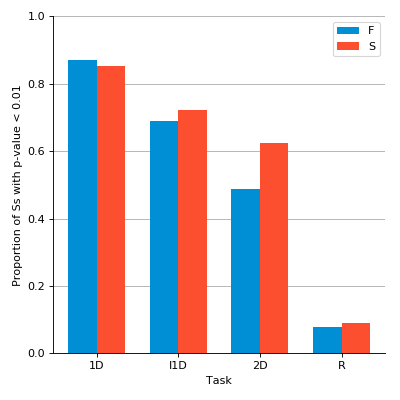

0 [134. 106.  75.  12.] [0.87012987 0.68831169 0.48701299 0.07792208]
1 [150. 127. 110.  16.] [0.85227273 0.72159091 0.625      0.09090909]


In [2]:
def learners_bars(path, alpha, figname, save_to, save_as):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3,4]
    
    first250 = lut.get_mask(data, {ix('trial'): 310}, '<=')
    data = data[first250, :]
    data[:, ix('trial')] -= 60
       
    fig = plt.figure(figname, figsize=[5,5])    
    ax = fig.add_subplot(1,1,1)
    bwidth = .35
    
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        counter = np.zeros(len(tasks))
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('sc')]
            pcs = data[mask, ix('pc1'):ix('p1')]
            learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)
            learnt_inds, = np.nonzero(learnt)
            counter[learnt_inds] += 1
        
        fracs = counter / gsids.size
        print(grp, counter, fracs)
        ax.bar((np.arange(len(tasks))-bwidth/2)+grp*bwidth, fracs, bwidth,
                color=gcolors[grp], label=glabels[grp], zorder=3)
    ax.legend()
    vut.despine(ax, 'right,top'.split(','))
    ax.grid(True, axis='y', zorder=0)
    ax.set_ylabel('Proportion of Ss with p-value < {}'.format(alpha))
    ax.set_xlabel('Task')
    xTickMarks = [tlabels[tsk] for tsk in tasks]
    ax.set_xticks(np.arange(len(tasks)))
    xtickNames = ax.set_xticklabels(xTickMarks)
    ax.set_ylim(0,1)
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=True)
        

def learners_lines(path, alpha, figname, save_to, save_as):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3,4]
    
    first250 = lut.get_mask(data, {ix('trial'): 310}, '<=')
    data = data[first250, :]
    data[:, ix('trial')] -= 60
       
    fig = plt.figure(figname, figsize=[5,5])    
    ax = fig.add_subplot(1,1,1)
    
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        counter = np.zeros(len(tasks))
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('sc')]
            pcs = data[mask, ix('pc1'):ix('p1')]
            learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)
            counter[np.nonzero(learnt)] += 1
        fracs = counter / gsids.size
        ax.plot(fracs, color=colors[grp], label=glabels[grp], zorder=3, lw=2.5,
                marker='s' if grp else 'o')
    ax.legend()
    vut.despine(ax, 'right,top'.split(','))
    ax.grid(True, axis='y', zorder=0)
    ax.set_ylabel('Proportion of Ss with p-value < {}'.format(alpha))
    ax.set_xlabel('Task')
    xTickMarks = [tlabels[tsk] for tsk in tasks]
    ax.set_xticks(np.arange(len(tasks)))
    xtickNames = ax.set_xticklabels(xTickMarks)
    ax.set_ylim(0,1)
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=True)        
        

def learning_points(path, alpha, figname, save_to, save_as):
    def first_nonzero(arr, axis, invalid_val=-1):
        mask = arr!=0
        return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)
    
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3]
    inds = np.arange(len(tasks))
    
    first250 = lut.get_mask(data, {ix('trial'): 310}, '<=')
    data = data[first250, :]
    data[:, ix('trial')] -= 60
       
    fig = plt.figure(figname, figsize=[5,5])    
    ax = fig.add_subplot(1,1,1)
    
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        first_lps = []
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')]
            first_lp = first_nonzero(np.logical_and(pvals < alpha, pcs > 0.5),
                                     axis=0, invalid_val=-1).astype(float)
            first_lp[first_lp < 0] = np.nan
            first_lps.append(first_lp)

        first_lps = np.vstack(first_lps)    
        means = np.nanmean(first_lps, axis=0)
        sem = scs.sem(first_lps, nan_policy='omit')

        ax.errorbar(inds+.03 if grp else inds-.03, 
                    means, yerr=sem, color=colors[grp], label=glabels[grp], zorder=3, 
                    lw=1, marker='s' if grp else 'o', capsize=4)

    ax.legend(loc='upper left')
    vut.despine(ax, 'right,top'.split(','))
    ax.grid(True, axis='y', zorder=0)
    ax.set_ylabel('Time of first learning point'.format(alpha))
    ax.set_xlabel('Task')
    xTickMarks = [tlabels[tsk] for tsk in tasks]
    ax.set_xticks(inds)
    xtickNames = ax.set_xticklabels(xTickMarks)
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=True)           
        

def switch_lags(path, alpha, figname, save_to, save_as, compress=True):
    data = lut.unpickle(path)

    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch,sw_act'.split(',')
    ix = cols.index
    
    groups, = lut.get_unique(data, [ix('grp')])
    
    outdata = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')]
            first_lp = lut.first_nonzero(np.logical_and(pvals < alpha, pcs > 0.5),
                                     axis=0, invalid_val=-1).astype(float).astype(int)
            if np.all(first_lp < 0):
                continue
            
            switches_after_lp = []
            for lp in first_lp:
                switches_after_lp.append(
                    lut.first_nonzero(data[mask, ix('sw_act')][lp:], axis=0) if lp >= 0 else np.nan
                )
            
            outdata.append([sid, grp, 
                            *first_lp.tolist(), 
                            *switches_after_lp])

    outdata = np.stack(outdata, axis=0)
    
    fig = plt.figure(figname, figsize=[5, 5])

    ax = fig.add_subplot(111)
    vut.line_histogram(
        ax = ax,
        data = np.nanmean(outdata[:, 5:8], axis=1),
        bins = np.arange(0, 140, 10),
        label = '.',
        c = 'k',
        lw = 2
    )
    ax.set_title('Distribution of switch lags')
    ax.set_xlabel('Time of first switch\nafter the first learning point')
    ax.set_ylabel('Relative frequency')
    
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as)

if 1:
    alpha_level = .01
    svg = ''
    
    learners_bars('pipeline_data/scdata/joint_data5.pkl', alpha_level,
          figname='learners_bars', save_to=saveloc, save_as=svg)
    
#     learners_lines('pipeline_data/scdata/joint_data5.pkl', alpha_level,
#           figname='learners_lines', save_to=saveloc, save_as=svg)
    
#     learning_points('pipeline_data/scdata/joint_data5.pkl', alpha_level,
#           figname='learning_points', save_to=saveloc, save_as=svg)
    
    # switch_lags(path = 'pipeline_data/scdata/joint_data_with_switches.pkl',
    #             alpha = alpha_level,
    #             figname = 'switch_lags',
    #             save_to = desktop,
    #             save_as = 'png')

## 18.4. Visualize IV: SC and learning

<IPython.core.display.Javascript object>


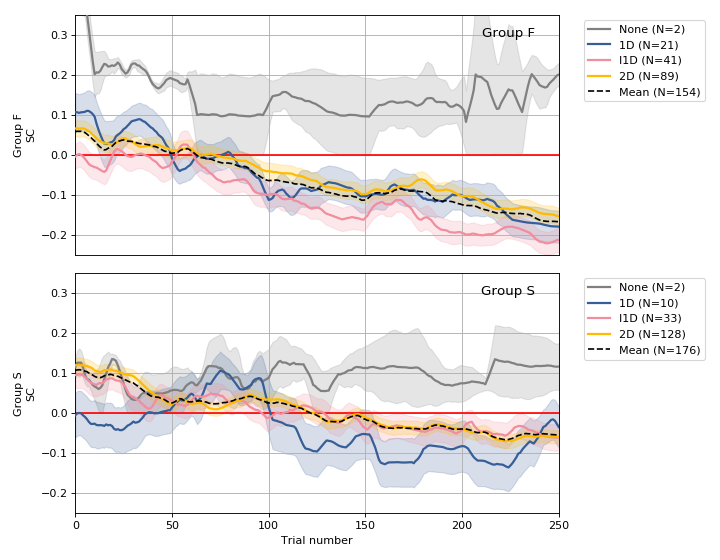

<IPython.core.display.Javascript object>


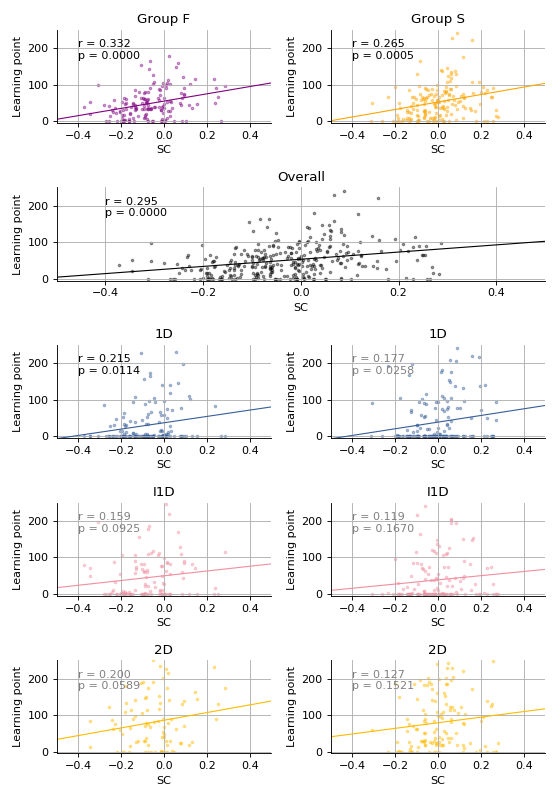

In [6]:
def sc_and_breadth(path, alpha, figname, save_to, save_as, compress, smooth=False):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
    
       
    fig = plt.figure(figname, figsize=[9,7])    
    colors_ = colors[:]

    for grp in groups:
        ax = fig.add_subplot(2,1,1+grp)
        ax.axhline(0, color='r', zorder=2)
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))

        sc_scores = []
        all_scores = []
        N = 0
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('sc')]
            pcs = data[mask, ix('pc1'):ix('p1')]
            learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)

            if not np.any(learnt):
                N += 1
                sc_scores.append(data[mask, ix('sc')])
            all_scores.append(data[mask, ix('sc')])
        
        if sc_scores:            
            sc_scores = np.vstack(sc_scores)
            if smooth:
                mean = vut.smooth(np.nanmean(sc_scores, axis=0), smooth, 'flat')
                sem = vut.smooth(scs.sem(sc_scores, nan_policy='omit'), smooth, 'flat')              
            else:
                mean = np.nanmean(sc_scores, axis=0)
                sem = scs.sem(sc_scores, nan_policy='omit')

            ax.plot(np.arange(0,mean.size), mean,
                    color='gray', label='None (N={})'.format(N), 
                    lw=2, alpha=1, zorder=3)
            ax.fill_between(np.arange(0,mean.size), mean-sem, mean+sem, alpha=.2,
                           color='gray')
        
        for ti, tsk in enumerate([1,2,3]):
            sc_scores = []
            N = 0
            for sid in gsids:
                mask = lut.get_mask(data, {ix('sid'): sid})
                pvals = data[mask, ix('p1'):ix('p4')]
                pcs = data[mask, ix('pc1'):ix('pc4')]
                learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)
                learnt_inds, = np.nonzero(learnt)
                
                if learnt_inds.size and np.max(learnt_inds)+1 == tsk:
                    N += 1
                    sc_scores.append(data[mask, ix('sc')])
                
            sc_scores = np.vstack(sc_scores)
            
            if smooth:
                mean = vut.smooth(np.nanmean(sc_scores, axis=0), smooth, 'flat')
                sem = vut.smooth(scs.sem(sc_scores, nan_policy='omit'), smooth, 'flat')              
            else:
                mean = np.nanmean(sc_scores, axis=0)
                sem = scs.sem(sc_scores, nan_policy='omit')

            ax.plot(np.arange(0,mean.size), mean,
                    color=colors_[ti], label='{} (N={})'.format(tlabels[tsk], N), 
                    lw=2, alpha=1, zorder=3)
            ax.fill_between(np.arange(0,mean.size), mean-sem, mean+sem, alpha=.2,
                           color=colors_[ti])
        
        all_scores = np.vstack(all_scores)    
        if smooth:
            mean = vut.smooth(np.nanmean(all_scores, axis=0), smooth, 'flat')       
        else:
            mean = np.nanmean(all_scores, axis=0)
        ax.plot(np.arange(0,mean.size), mean,
                    color='k', label='Mean (N={})'.format(gsids.size), 
                    lw=1.5, alpha=1, zorder=3, ls='--')
            
            
        ax.set_ylim(-.25,.35)
        ax.set_xlim(0,250)
        ax.grid(True, zorder=0)
        if not grp:
            plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off
        else:
            ax.set_xlabel('Trial number')

        ax.set_ylabel('Group {}\nSC'.format(glabels[grp]))
        ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
        ax.text(.95,.95,'Group {}'.format(glabels[grp]), ha='right', va='top',
                transform=ax.transAxes, fontsize=12)
        
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)

        
def sc_and_numtasks(path, alpha, figname, save_to, save_as, compress, smooth=False):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
    
       
    fig = plt.figure(figname, figsize=[9,7])    
    colors_ = colors[:]
    # colors_[2] = '#B2B816'
    colors_ = ['gray'] + colors_
    for grp in groups:
        ax = fig.add_subplot(2,1,1+grp)
        ax.axhline(0, color='r', zorder=2)
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))

        for n in range(4):
            sc_scores = []
            all_scores = []
            N = 0
            for sid in gsids:
                mask = lut.get_mask(data, {ix('sid'): sid})
                pvals = data[mask, ix('p1'):ix('sc')]
                pcs = data[mask, ix('pc1'):ix('p1')]
                learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)
                
                if learnt.sum() == n:  
                    sc_scores.append(data[mask, ix('sc')])
                    N += 1
                all_scores.append(data[mask, ix('sc')])
                
            sc_scores = np.vstack(sc_scores)
                
            if smooth:
                mean = vut.smooth(np.nanmean(sc_scores, axis=0), smooth, 'flat')
                sem = vut.smooth(scs.sem(sc_scores, nan_policy='omit'), smooth, 'flat')              
            else:
                mean = np.nanmean(sc_scores, axis=0)
                sem = scs.sem(sc_scores, nan_policy='omit')

            ax.plot(np.arange(0,mean.size), mean,
                    color=colors_[n], label='{} (N={})'.format(n, N), 
                    lw=2, alpha=1, zorder=3)
            ax.fill_between(np.arange(0,mean.size), mean-sem, mean+sem, alpha=.2,
                           color=colors_[n])
        all_scores = np.vstack(all_scores)    
        if smooth:
            mean = vut.smooth(np.nanmean(all_scores, axis=0), smooth, 'flat')       
        else:
            mean = np.nanmean(all_scores, axis=0)
        ax.plot(np.arange(0,mean.size), mean,
                    color='k', label='Mean (N={})'.format(gsids.size), 
                    lw=1.5, alpha=1, zorder=3, ls='--')
        
        ax.set_ylim(-.25,.35)
        ax.set_xlim(0,250)
        ax.grid(True, zorder=0)
        
        if not grp:
            plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off
        else:
            ax.set_xlabel('Trial number')

        ax.set_ylabel('SC')
        ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
        ax.text(.95,.95,'Group {}'.format(glabels[grp]), ha='right', va='top',
                transform=ax.transAxes, fontsize=12)

    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)
        

def sc_and_learning_points(path, alpha, figname, save_to, save_as, compress=False):
    
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3]
    inds = np.arange(len(tasks))
    
    first250 = lut.get_mask(data, {ix('trial'): 310}, '<=')
    data = data[first250, :]
    data[:, ix('trial')] -= 60
    
    fig = plt.figure(figname, figsize=[7,10])    
    ax = fig.add_subplot(5,1,2)
    
    plot_data = []
    sc_scores, lps = [], []
    
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            smask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[smask, ix('p1'):ix('p4')]
            pcs = data[smask, ix('pc1'):ix('pc4')]    
            first_lp = lut.first_nonzero(np.logical_and(pvals < alpha, pcs > 0.5),
                                     axis=0, invalid_val=-1).astype(float)
            first_lp[first_lp < 0] = np.nan
            if np.all(np.isnan(first_lp)): 
                continue
            plot_data.append([sid, grp, 
                              np.nanmean(data[smask, ix('sc')]),
                              ]+[lp for lp in first_lp])
    
    # columns: | sid | grp | sc | lp1 | lp2 | lp3 |
    plot_data = np.vstack(plot_data)
    
    x, y = plot_data[:, 2],  np.nanmean(plot_data[:, 3:], axis=1)
    vut.pretty_scatter(x, y, ax,[-.5,.5], [-5,250], 'SC', 'Learning point', 'k', 'k',
                      'top-left')
    ax.set_title('Overall')
    
    gcolors = ['purple', 'orange']
    for grp in groups:
        ax = fig.add_subplot(5,2,1+grp)
        gmask = lut.get_mask(plot_data, {1: grp})
        
        x, y = plot_data[gmask, 2],  np.nanmean(plot_data[gmask, 3:], axis=1) 
        vut.pretty_scatter(x, y, ax,[-.5,.5], [-5,250], 'SC', 'Learning point', 
                           gcolors[grp], gcolors[grp], 'top-left')
        ax.set_title('Group {}'.format(glabels[grp]))
        
        for ti, tsk in enumerate(tasks):
            ax = fig.add_subplot(5, 2, 5+grp + ti*2)
            gmask = lut.get_mask(plot_data, {1: grp})

            x, y = plot_data[gmask, 2], plot_data[gmask, 3+ti]
            
            vut.pretty_scatter(x, y, ax,[-.5,.5], [-5,250], 'SC', 'Learning point', 
                               colors[ti], colors[ti], 'top-left')
            ax.set_title(tlabels[tsk])

        
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)       


def rselect_and_numtasks(path, alpha, figname, save_to, save_as, compress, smooth=False):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
    
       
    fig = plt.figure(figname, figsize=[9,7])    
    colors_ = colors[:]
    # colors_[2] = '#B2B816'
    colors_ = ['gray'] + colors_
    for grp in groups:
        ax = fig.add_subplot(2,1,1+grp)
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))

        for n in range(1,4):
            played_r = []
            all_scores = []
            N = 0
            for sid in gsids:
                mask = lut.get_mask(data, {ix('sid'): sid})
                pvals = data[mask, ix('p1'):ix('sc')]
                pcs = data[mask, ix('pc1'):ix('p1')]
                learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)
                
                if learnt.sum() == n:  
                    played_r.append(data[mask, ix('t0')]==4)
#                     played_r.append(
#                         pcs[
#                             np.arange(pvals.shape[0]), 
#                             data[mask, ix('t0')].astype(int)-1
#                         ]
#                     )
                    N += 1
                
#                 all_scores.append(data[mask, ix('t0')]==4)
                
            played_r = np.vstack(played_r)
                
            ps_r = np.sum(played_r, axis=0) / played_r.shape[0]
#             ps_r = np.mean(played_r, axis=0)
            if smooth:
                ps_r = vut.smooth(ps_r, smooth, 'flat') 
                
            ax.plot(np.arange(0, ps_r.size), ps_r,
                    color=colors_[n], label='{} (N={})'.format(n, N), 
                    lw=2, alpha=1, zorder=3)

#         all_scores = np.vstack(all_scores)    
#         ps_r = np.sum(all_scores, axis=0) / all_scores.shape[0]
#         if smooth:
#             ps_r = vut.smooth(ps_r, smooth, 'flat') 
            
#         ax.plot(np.arange(0,ps_r.size), ps_r,
#                     color='k', label='Mean (N={})'.format(gsids.size), 
#                     lw=1.5, alpha=1, zorder=3, ls='--')
        
        ax.set_ylim(-.02, 1.02)
        ax.set_xlim(0, 250)
        ax.grid(True, zorder=0)
        
        if not grp:
            plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off
        else:
            ax.set_xlabel('Trial number')

        ax.set_ylabel('% of R selection')
        ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
        ax.text(.95, .95,'Group {}'.format(glabels[grp]), ha='right', va='top',
                transform=ax.transAxes, fontsize=12)

    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)
        
        
if 1:
    alpha_level = .02
    sc_and_breadth(path='pipeline_data/scdata/joint_data5.pkl', alpha=alpha_level,
                  figname='sc_and_breadth_hardest', save_to=saveloc, save_as='', 
                  compress=True, smooth=5)
    
    # sc_and_numtasks(path='pipeline_data/scdata/joint_data5.pkl', alpha=alpha_level,
    #               figname='sc_and_breadth_numtasks', save_to=saveloc, save_as='',
    #               compress=True, smooth=5)

    # rselect_and_numtasks(path='pipeline_data/scdata/joint_data5.pkl', alpha=alpha_level,
    #               figname='rsel_and_breadth', save_to=saveloc, save_as='',
    #               compress=True, smooth=5)
    # sc_and_learning_points(path='pipeline_data/scdata/joint_data5.pkl',
    #                        alpha=alpha_level,
    #                        figname='sc_and_learning_points',
    #                        save_to=saveloc,
    #                        save_as='svg',
    #                        compress=True)

## 18.5. Visualize V: SC and metacognitive accuracy

In [ ]:
def very_pretty_scatter1(x, y, ax, groups, gcolors, m='o', xlim=None, ylim=None, xlabel=None, ylabel=None, textpos='top-right'):
    groups = groups.astype(int)
    
    rho = pearsonr(x,y)
    x_ = sm.add_constant(x)
    model = sm.OLS(y, x_)
    results = model.fit()
    linex, liney = xlim
    label = 'F and S'
    res = '\nr={:.3f}, p={:.3f}'.format(rho[0], rho[1])
    sign = ' **' if rho[1] < .01 else ' *' if rho[1] < .05 else ''

    ax.plot(np.array([linex, liney]), 
        results.params[0] + np.array([linex, liney])*results.params[1],
        lw=1, c='k', label=label+sign+res)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
        
    for grp in np.unique(groups):
        rho = pearsonr(x[groups==grp], y[groups==grp])
        ax.scatter(x[groups==grp], y[groups==grp],  alpha=.4,
               marker=m, s=5, color=gcolors[grp])
        x_ = sm.add_constant(x[groups==grp])
        model = sm.OLS(y[groups==grp], x_)
        results = model.fit()
        linex, liney = xlim
                                              
        label = glabels[grp]
        res = '\nr={:.3f}, p={:.3f}'.format(rho[0], rho[1])
        sign = ' **' if rho[1] < .01 else ' *' if rho[1] < .05 else ''

        ax.plot(np.array([linex, liney]), 
            results.params[0] + np.array([linex, liney])*results.params[1],
            lw=1, ls='--', c=gcolors[grp],
            label=label+sign+res)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    ax.grid(True)

    
def sc_cor_ma(path1, path2, figname,
          save_to=saveloc, save_as=None, compress=True):
    data1 = lut.unpickle(path1)
    
    tasks = [1,2,3,4]
    
    A  = ['sid', 'grp']
    B  = ['ps_{}'.format(t) for t in tasks]
    C  = ['pct_{}'.format(t) for t in tasks]
    D  = ['pcf_{}'.format(t) for t in tasks]
    D1 = ['pctst_{}'.format(t) for t in tasks]
    E  = ['lrn_{}'.format(t) for t in tasks]
    F  = ['int_{}'.format(t) for t in tasks]
    G  = ['comp_{}'.format(t) for t in tasks]
    H  = ['time_{}'.format(t) for t in tasks]
    I  = ['prog_{}'.format(t) for t in tasks]
    J  = ['rule_{}'.format(t) for t in tasks]
    K  = ['lrn2_{}'.format(t) for t in tasks]
    L  = ['alv']
    
    cols1 = [*A, *B, *C, *D, *D1, *E, *F, *G, *H, *I, *J, *K, *L]
    ix1 = cols1.index  
    
    data2 = lut.unpickle(path2)
    cols2 = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix2 = cols2.index
    
    data2[:, ix2('trial')] -= 60
    first250 = lut.get_mask(data2, {ix2('trial'): 250}, '<')
    data2 = data2[first250, :]
    
    fig = plt.figure(figname, figsize=[5,14])
    
    sids, groups = lut.get_unique(data1, [ix1('sid'), ix1('grp')])
    
    # pdata cols: 
    # 0,1         : sid, grp
    # 2,3,4,5     : learnability
    # 6,7,8,9     : interest
    # 10,11,12,13 : complexity
    # 14,15,16,17 : time
    # 18,19,20,21 : progress
    # 22,23,24,25 : rule
    # 26,27,28,29 : lrn2
    # 30,31       : alv, sc

    f2_data = []
    f1_data = []
    for sid in sids:
        smask1 = lut.get_mask(data1, {ix2('sid'): sid})
        smask2 = lut.get_mask(data2, {ix2('sid'): sid})
        
        grp = data1[smask1, ix1('grp')][0]
        pc1 = data1[smask1, [ix1(i) for i in D1]]
        pc0 = data1[smask1, [ix1(i) for i in C]]
        if np.any(np.isnan(pc1)):
            continue
        dpcs = pc1[~np.isnan(pc1)] - pc0[~np.isnan(pc1)]
        progs = data1[smask1, ix1('prog_1'):ix1('prog_4')+1].squeeze()[~np.isnan(pc1)]
        rho, prob = pearsonr(dpcs,progs)
        
        sc = np.nanmean(np.abs(data2[smask2, ix2('sc')]))

        f2_data.append([sid, grp, sc, rho])
        f1_data.append([sid, 
                       grp, 
                       np.mean(pc0),
                       np.nanmean(pc1),
                       np.mean(dpcs),
                       np.mean(progs)])

    f2_data = np.stack(f2_data, axis=0)
    f1_data = np.stack(f1_data, axis=0)

    ax = fig.add_subplot(411)
    vut.pretty_scatter(
        x = f1_data[:, 4], 
        y = f1_data[:, 5],
        ax = ax,
        xlim = [-.55,.55], 
        ylim = [0.8, 10.2],
        xlabel = 'dPC\n(mean across tasks tested)', 
        ylabel = 'Self-reported progress\n(mean across 4 tasks)',
        textpos = 'bottom-left')
    ax.set_title('(a) Subjective progress as a function of dPC')
    
    ax = fig.add_subplot(412)
    vut.pretty_scatter(
        x = f1_data[:, 3], 
        y = f1_data[:, 5],
        ax = ax,
        xlim = [.2,1.05], 
        ylim = [0.8, 10.2],
        xlabel = 'Test PC\n(mean across tasks tested)', 
        ylabel = 'Self-reported progress\n(mean across 4 tasks)',
        textpos = 'bottom-left')
    ax.set_title('(b) Subjective progress as a function of test PC')
    
    ax = fig.add_subplot(413)
    x, y = f2_data[:,2], f2_data[:,3]
    vut.pretty_scatter(x, y,
                       ax, [0,.6], [-1.05,1.05],
                       'Strategicness', 'Metacognitive accuracy',
                        textpos='bottom-right')
    ax.set_title('(c) Strategy and metacognitive accuracy')
    
    ax = fig.add_subplot(414)
    for grp in groups:
        gmask = lut.get_mask(f2_data, {1:grp})
        data = f2_data[gmask,3]
        
        vut.line_histogram(ax = ax, 
                           data = data[~np.isnan(data)], 
                           bins=np.arange(-1,1.3,.2), label=glabels[grp],
                           c=colors[grp], lw=2)
    ax.set_title('(d) Histograms of calibration scores')
    ax.set_ylabel('Relative frequency')
    ax.set_xlabel('Correlation coefficients between\nsubjective and measured progress')
    
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, 
                save_as=save_as, compress=compress)     
    

def pval_cor_rule(path1, path2, figname,
          save_to=saveloc, save_as=None, compress=True):
    data1 = lut.unpickle(path1)
    
    tasks = [1,2,3,4]
    
    A  = ['sid', 'grp']
    B  = ['ps_{}'.format(t) for t in tasks]
    C  = ['pct_{}'.format(t) for t in tasks]
    D  = ['pcf_{}'.format(t) for t in tasks]
    D1 = ['pctst_{}'.format(t) for t in tasks]
    E  = ['lrn_{}'.format(t) for t in tasks]
    F  = ['int_{}'.format(t) for t in tasks]
    G  = ['comp_{}'.format(t) for t in tasks]
    H  = ['time_{}'.format(t) for t in tasks]
    I  = ['prog_{}'.format(t) for t in tasks]
    J  = ['rule_{}'.format(t) for t in tasks]
    K  = ['lrn2_{}'.format(t) for t in tasks]
    L  = ['alv']
    
    cols1 = [*A, *B, *C, *D, *D1, *E, *F, *G, *H, *I, *J, *K, *L]
    ix1 = cols1.index  
    
    data2 = lut.unpickle(path2)
    cols2 = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix2 = cols2.index
    
    data2[:, ix2('trial')] -= 60
    first250 = lut.get_mask(data2, {ix2('trial'): 250}, '<')
    data2 = data2[first250, :]
    
    fig = plt.figure(figname, figsize=[6,5])
    
    sids, groups = lut.get_unique(data1, [ix1('sid'), ix1('grp')])
    
    # pdata cols: 
    # 0,1         : sid, grp
    # 2,3,4,5     : learnability
    # 6,7,8,9     : interest
    # 10,11,12,13 : complexity
    # 14,15,16,17 : time
    # 18,19,20,21 : progress
    # 22,23,24,25 : rule
    # 26,27,28,29 : lrn2
    # 30,31       : alv, sc

    ax = fig.add_subplot(111)    
    ticks = np.array(tasks)
    width = 0.35
    
    ax.set_xticks(ticks)
    ax.set_xticklabels([tlabels[tsk] for tsk in tasks], rotation=0)
    ax.grid(axis='y', zorder=0)
    ax.set_ylim(0,.1)
    vut.despine(ax, ['top', 'right'])
    ax.set_ylabel('Average minimum p-value')
    ax.set_xlabel('Task')    
    
    for ti, tsk in enumerate(tasks):
        # ax = fig.add_subplot(2,2,tsk)
        pvals, rules = [], []

        for sid in sids:
            smask1 = lut.get_mask(data1, {ix2('sid'): sid})
            smask2 = lut.get_mask(data2, {ix2('sid'): sid})

            # zrules = scs.zscore(data1[smask1, ix1('rule_1'):ix1('lrn2_1')].squeeze())
            rule = data1[smask1, ix1('rule_1'):ix1('rule_4')+1].squeeze()[ti]
            pval = np.min(data2[smask2, ix2('p{}'.format(tsk))])

            rules.append(rule)
            pvals.append(pval)

        rules = np.array(rules)
        pvals = np.array(pvals)

        means = []
        sems = []
        ranges = [[1,5],[6,10]]
        for rng in ranges:
            scores = pvals[np.logical_and(rules>=rng[0], rules<=rng[1])]
            means.append(np.mean(scores))
            sems.append(scs.sem(scores))

        low  = ax.bar(ticks[ti]-width/2, means[0], width, 
                      color=gcolors[0], zorder=2)
        high = ax.bar(ticks[ti]+width/2, means[1], width, 
                      color=gcolors[1], zorder=2)
        
        ax.errorbar(ticks[ti]-width/2, means[0], yerr=sems[0], 
                    capsize=3, color='k', zorder=3)
        ax.errorbar(ticks[ti]+width/2, means[1], yerr=sems[1],
                    capsize=3, color='k', zorder=3)
        
    ax.legend( (low[0], high[0]), ('No rule (scores <= 5)', 'Rule (scores > 5)') )    
    #         vut.pretty_scatter(x=rules, y=pvals, ax=ax, 
    #                            xlim=[0, 10], ylim=[0,.2],
    #                            xlabel='Standardized rule rating',
    #                            ylabel='Average p-value',
    #                            dot_col=colors[tsk-1],
    #                            line_col=colors[tsk-1])
 
    
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, 
                save_as=save_as, compress=compress)     
    

if 1: 
    # sc_cor_ma(path1='pipeline_data/selection_rates/data_v3.pkl',
    #           path2='pipeline_data/scdata/joint_data5.pkl',
    #           figname='sc_cor_ma',
    #           save_to=saveloc, save_as='', compress=True)
    
    pval_cor_rule(path1='pipeline_data/selection_rates/data_v3.pkl',
          path2='pipeline_data/scdata/joint_data5.pkl',
          figname='pval_cor_rule',
          save_to=saveloc, save_as='svg', compress=True)

## 18.6. SC and time spent on each task

In [3]:
def sc_cor_time(path, figname,
          save_to=saveloc, save_as=None, compress=True):
    
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix = cols.index
    
    data[:, ix('trial')] -= 60
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
    
    fig = plt.figure(figname, figsize=[7,12])
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    
    outdata = []
    
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = np.unique(data[gmask, ix('sid')])
        
        for sid in gsids:
            srow = [grp]
            mask = lut.get_mask(data, {ix('sid'): sid})
            
            played, counts = np.unique(data[mask, ix('t0')], return_counts=True)
            for ti, tsk in enumerate([1,2,3,4]):
                if tsk in played:
                    srow.append(*counts[np.where(played==tsk)]/counts.sum())
                else: srow.append(0)
            srow.append(
                np.nanmean(data[mask, ix('sc')])
            )
            outdata.append(srow)
    
    outdata = np.stack(outdata, axis=0)
    

    for tsk in [1,2,3,4]:
        ax = fig.add_subplot(4,1,tsk)
        ax.set_title(tlabels[tsk])
        very_pretty_scatter1(
            x = outdata[:, -1],
            y = outdata[:, tsk],
            ax = ax,
            groups = outdata[:, 0],
            gcolors = colors[:2],
            xlim = [-.6,.6],
            ylim = [-.05, 1.05],
            xlabel = 'SC',
            ylabel = 'Time spent on task'
        )
    
        ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    fig.tight_layout()
    
if 1:
    sc_cor_time(path = 'pipeline_data/scdata/joint_data5.pkl',
                figname = 'tempname', 
                save_to = desktop, 
                save_as = '', 
                compress = False)
    

<IPython.core.display.Javascript object>

NameError: name 'very_pretty_scatter1' is not defined

# 19. Performance and learnability generalization

## 19.1. Prepere data

In [ ]:
def prepare_data19(path, pickle_path=None, null=.5, print_data=False):
    outdata = []
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch,sw_act'.split(',')
    ix = cols.index
    
    mdata, xdata = [lut.unpickle(path)[k] for k in ['main', 'extra']]

    sids, groups, conds, tasks, monsters = lut.get_unique(mdata, [r.ix('sid'), 
                                                                  r.ix('group'),
                                                                  r.ix('cond'),
                                                                  r.ix('cat'),
                                                                  r.ix('fam')])
    monsters = monsters.tolist()
    
    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})

    mdata[freeplay, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    outdata = []
    for grp in groups:
        for cnd in conds:
            gcmask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('cond'): cnd})
            gcsids = lut.get_unique(mdata[gcmask,:], r.ix('sid'))
            n = gcsids.size

            for sid in gcsids:
                sdata = mdata[lut.get_mask(mdata, {r.ix('sid'): sid}), :]
                sid_data = np.zeros([sdata.shape[0], len(cols)])                

                features = [sid, grp, cnd]
                pcs, pvals = [],[]
                for ti, tsk in enumerate(tasks):
                    tmask = lut.get_mask(sdata, {r.ix('cat'): tsk})

                    trials_so_far = np.cumsum(tmask)
                    cor_on_task = np.zeros(sid_data.shape[0])
                    cor_on_task[tmask] = sdata[tmask, r.ix('cor')]
                    cor_so_far = np.cumsum(cor_on_task)

                    with np.errstate(divide='ignore', invalid='ignore'):
                        pcs.append(np.nanmean(
                            cor_so_far / trials_so_far))
                        pvals.append(np.nanmean(
                            lut.p_val(trials_so_far, cor_so_far, null)))
                features += pcs + pvals
                        
                for tsk in tasks:
                    # LRN ratings
                    train = mdata[lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 0}), :]
                    mask = lut.get_mask(train, {r.ix('cat'): tsk})
                    mi = monsters.index(train[mask, r.ix('fam')][0])

                    mask = lut.get_mask(xdata, {r.ix('sid'): sid})
                    features.append(xdata[mask, rx.ix('q6m1') + mi * 7][0].astype(int))

                for q in [1,2,3,4,5,7]:
                    for tsk in tasks:
                        # cols 42:46 = questions
                        mask = lut.get_mask(train, {r.ix('cat'): tsk})
                        mi = monsters.index(train[mask, r.ix('fam')][0])                    

                        mask = lut.get_mask(xdata, {r.ix('sid'): sid})
                        features.append(xdata[mask, rx.ix('q{}m1'.format(q)) + mi * 7][0].astype(int))

                outdata.append(features)

    outdata = np.array(outdata)
        
    if print_data:
        A = ['sid', 'grp', 'cnd']
        B = ['pc_{}'.format(t) for t in tasks]
        C = ['p_{}'.format(t) for t in tasks]
        E = ['lrn_{}'.format(t) for t in tasks]
        F = ['int_{}'.format(t) for t in tasks]
        G = ['comp_{}'.format(t) for t in tasks]
        H = ['time_{}'.format(t) for t in tasks]
        I = ['prog_{}'.format(t) for t in tasks]
        J = ['rule_{}'.format(t) for t in tasks]
        K = ['lrn2_{}'.format(t) for t in tasks]

        cols = [*A, *B, *C, *E, *F, *G, *H, *I, *J, *K]
        lut.print_arr(outdata,
                     cols=cols,
                     nonints=[*B, *C],
                     round_=2, pretty=True)
    
    if pickle_path:
        lut.dopickle(pickle_path, outdata)
        return pickle_path
    else:
        return outdata
    
if 1: prepare_data19(path=data_path,
                   pickle_path='pipeline_data/rule_infer/data.pkl')

# 20. Self reports by group and condition

In [ ]:
def prep_split_self_report_data(path, pickle_path=None):
    mdata, xdata = [lut.unpickle(path)[k] for k in ['main', 'extra']]

    sids, groups, conds, tasks, monsters = lut.get_unique(mdata, [r.ix('sid'), 
                                                           r.ix('group'), 
                                                           r.ix('cond'),
                                                           r.ix('cat'),
                                                           r.ix('fam')])
    monsters = monsters.tolist()

    outdata = []
    for grp in groups:
        for cnd in conds:
            gcmask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('cond'): cnd})
            gcsids = lut.get_unique(mdata[gcmask,:], r.ix('sid'))
            n = gcsids.size

            for sid in gcsids:
                trainmask = lut.get_mask(mdata, {r.ix('sid'): sid, r.ix('stage'): 0})

                # cols 0:2 = sid and group
                features = [sid, grp, cnd]

                train = mdata[trainmask, :]

                for tsk in tasks:
                    # cols 18:42 = LRN ratings
                    mask = lut.get_mask(train, {r.ix('cat'): tsk})
                    mi = monsters.index(train[mask, r.ix('fam')][0])

                    mask = lut.get_mask(xdata, {r.ix('sid'): sid})
                    features.append(xdata[mask, rx.ix('q6m1') + mi * 7][0].astype(int))

                for q in [1,2,3,4,5,7]:
                    for tsk in tasks:
                        # cols 42:46 = questions
                        mask = lut.get_mask(train, {r.ix('cat'): tsk})
                        mi = monsters.index(train[mask, r.ix('fam')][0])                    

                        mask = lut.get_mask(xdata, {r.ix('sid'): sid})
                        features.append(xdata[mask, rx.ix('q{}m1'.format(q)) + mi * 7][0].astype(int))
                outdata.append(features)
    outdata = np.array(outdata)
    
    if pickle_path:
        lut.dopickle(pickle_path, outdata)
        return pickle_path
    else:
        return outdata

    
def split_self_reports(path, q, normalize=False, figname='mplfigure', save_as='svg'):
    data = lut.unpickle(path)
    
    tasks = np.array([1,2,3,4])
    cols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    ix = cols.index
    
    qdata = data[:, ix('{}_1'.format(q)):ix('{}_4'.format(q))+1].astype(float)
    
    if normalize:
        min_, max_ = np.min(qdata, axis=1).reshape([-1,1]), np.max(qdata, axis=1).reshape([-1,1])
        f = np.squeeze(min_ == max_)
        if np.any(f): qdata[f, :] = (qdata[f, :] - 1) / 10
        qdata[~f, :] = (qdata[~f, :] - min_[~f,:]) / (max_[~f,:] - min_[~f,:])

    plt.figure(figname, figsize=[4,8])  
    labels = [tlabels[l] for l in [1,2,3,4]]
    ylim = [0,1.05] if normalize else [.5,10.5]
    
    plt.subplot(3,1,1)
    y, yerr = qdata.mean(0), scs.sem(qdata, axis=0)
    
    plt.errorbar(tasks, y, yerr=yerr, lw=2, c='k')
    plt.xticks(tasks, labels)
    plt.ylim(ylim)
    plt.ylabel('Normalized score')
    plt.title('Overall `{}`'.format(q))
    plt.grid(True, axis='y')
    vut.despine(plt.gca(), ['top', 'right'])

    plt.subplot(3,1,2)
    for cnd in [0,1]:
        shift = .01 if cnd else -0.1
        cmask = lut.get_mask(data, {ix('cnd'): cnd})
        y, yerr = qdata[cmask, :].mean(0), scs.sem(qdata[cmask, :], axis=0)
        
        plt.errorbar(tasks+shift, y, yerr=yerr, lw=2, c=gcolors[cnd], 
                     label=clabels[cnd])        
        plt.xticks(tasks, labels)
        plt.title('Split by condition')
    plt.ylim(ylim)
    plt.ylabel('Normalized score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, axis='y')
    vut.despine(plt.gca(), ['top', 'right'])    

    plt.subplot(3,1,3)
    for grp in [0,1]:
        shift = .01 if grp else -0.1
        gmask = lut.get_mask(data, {ix('grp'): grp})
        y, yerr = qdata[gmask, :].mean(0), scs.sem(qdata[gmask, :], axis=0)

        plt.errorbar(tasks+shift, y, yerr=yerr, lw=2, c=gcolors[grp], 
                     label=glabels[grp])    
        plt.xticks(tasks, labels)
        plt.title('Split  by group')
    plt.ylim(ylim)
    plt.ylabel('Mean normalized score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, axis='y')
    vut.despine(plt.gca(), ['top', 'right'])

    plt.tight_layout()
    if save_as:
        save_it(plt.gcf(), saveloc, figname, save_as=save_as)

if 0: 
        prep_split_self_report_data('pipeline_data/s3/joint_data.pkl', 
                                'pipeline_data/s3/extra_data_good_form.pkl')

if 1:
    qs = 'lrn,int,prog,comp,time,lrn2,rule'.split(',')
    for s in qs:
        split_self_reports(path='pipeline_data/s3/extra_data_good_form.pkl', 
                       q=s,
                       normalize=True,
                       figname='norm_{}'.format(s),
                       save_as='')

## 20.1. Rule 2D and R

In [ ]:
def rule2D_R(path, qx, qy, normalize=False, figname='mplfigure', save_as='svg'):
    def donorm(x):
        min_, max_ = np.min(x, axis=1).reshape([-1,1]), np.max(x, axis=1).reshape([-1,1])
        f = np.squeeze(min_ == max_)
        if np.any(f): x[f, :] = (x[f, :] - 1) / 9
        x[~f, :] = (x[~f, :] - min_[~f,:]) / (max_[~f,:] - min_[~f,:])
        return x
    
    def pval2ast(x):
        if x < .01:
            return '**'
        elif x < .05:
            return '*'
        else:
            return ''
    
    data = lut.unpickle(path)
    
    tasks = np.array([1,2,3,4])
    cols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    ix = cols.index
    
    qxdata = data[:, ix('{}_1'.format(qx)):ix('{}_4'.format(qx))+1].astype(float)
    qydata = data[:, ix('{}_1'.format(qy)):ix('{}_4'.format(qy))+1].astype(float)
    if normalize:
        qxdata = donorm(qx)
        qydata = donorm(qy)
    
    plt.figure(num=figname, figsize=[8, 7])
    pos = tasks
    width = .2
    
    print('>>> Group split:')
    for grp in [0, 1]:
        plt.subplot(2,2,1+grp)
        plt.title('Group {}'.format(glabels[grp]))
        plt.ylim(-.5, .5)
        vut.despine(plt.gca(), ['top','right','bottom'])
        plt.axhline(0, c='k', lw=.5)
        plt.xticks([p + width*(len(tasks))/2 - width/2 for p in tasks], 
                   [tlabels[l] for l in tasks])
        plt.grid(True, axis='y', alpha=.5, zorder=0)
        plt.ylabel('Correlation coefficient')
        plt.xlabel(qy)
        
        print('    {}'.format(glabels[grp]))
        mask = lut.get_mask(data, {ix('grp'): grp})
        cor, pval = np.zeros([4,4]), np.zeros([4,4])
        for i,x in enumerate(qxdata[mask, :].T):
            for j,y in enumerate(qydata[mask, :].T):
                cor[i,j], pval[i,j] = scs.pearsonr(x,y)
            plt.bar(
                [p + width*i for p in pos],
                cor[i, :],
                width,
                color=colors[i],
                label=tlabels[i+1],
                zorder=2
            )
            sig = [pval2ast(z) for z in pval[i, :]]
            for tsk in tasks:
                plt.text(x = tsk + width*i, 
                         y = cor[i,tsk-1]+np.sign(cor[i,tsk-1])*.05, 
                         s = sig[tsk-1], ha='center', va='center')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=qx)

        np.set_printoptions(precision=3)
        print(cor)
        print(pval < .05)
        
    print('>>> Cond split:')
    for cnd in [0, 1]:
        plt.subplot(2,2,3+cnd)
        plt.title('Condition {}'.format(clabels[cnd]))
        plt.ylim(-.5, .5)
        vut.despine(plt.gca(), ['top','right','bottom'])
        plt.axhline(0, c='k', lw=.5)
        plt.xticks([p + width*(len(tasks))/2 - width/2 for p in tasks], 
                   [tlabels[l] for l in tasks])
        plt.grid(True, axis='y', alpha=.5, zorder=0)
        plt.ylabel('Correlation coefficient')
        plt.xlabel(qy)
        
        print('    {}'.format(clabels[cnd]))
        mask = lut.get_mask(data, {ix('cnd'): cnd})
        cor, pval = np.zeros([4,4]), np.zeros([4,4])
        for i,x in enumerate(qxdata[mask, :].T):
            for j,y in enumerate(qydata[mask, :].T):
                cor[i,j], pval[i,j] = scs.pearsonr(x,y)
            plt.bar(
                [p + width*i for p in pos],
                cor[i, :],
                width,
                color=colors[i],
                label=tlabels[i+1],
                zorder=2
            )
            sig = [pval2ast(pv) if r != 1 else '' for pv, r in zip(pval[i, :], cor[i, :])]
            for tsk in tasks:
                plt.text(x = tsk + width*i, 
                         y = cor[i,tsk-1]+np.sign(cor[i,tsk-1])*.05, 
                         s = sig[tsk-1], ha='center', va='center')
                
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=qx)

        np.set_printoptions(precision=3)
        print(cor)
        print(pval < .05)
    
#     plt.figure(figname, figsize=[4,4])  
#     labels = [tlabels[l] for l in [1,2,3,4]]
#     ylim = [0,1.05] if normalize else [.5,10.5]
    
#     plt.subplot(1,1,1)
    

    
#     plt.scatter(x,y, alpha=0.5)
    
#     plt.ylim(ylim)
#     plt.ylabel('Normalized score')
#     plt.title('Overall `{}`'.format(q))
#     plt.grid(True, axis='y')
#     vut.despine(plt.gca(), ['top', 'right'])

    plt.tight_layout()
    if save_as:
        save_it(plt.gcf(), saveloc, 'corrs_{}_{}'.format(qx, qy), save_as=save_as)

if 1:
    # the more/less X (legend) the more/less Y (x axis)
    rule2D_R(path='pipeline_data/s3/extra_data_good_form.pkl',
             qx='rule',
             qy='int',
             normalize=False,
             figname='figure',
             save_as='svg')

In [ ]:
# 21. Streak length as a function of time